In [2]:
from tools_stance import * 
from models import *
import torch 
import pandas as pd

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

path="../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

SyntaxError: invalid syntax (<ipython-input-2-5e4b38d09488>, line 1)

In [2]:
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))
j=220
labs=['support', 'denying', 'questioning', 'commenting']
data=[train['Label'], val['Label'], test["Label"]]
name=["Training", "Validation", "Testing"]
for i in range(3):
    j+=1
    h=fig.add_subplot(j)
    ax= sns.countplot(data[i], order=labs)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    h.title.set_text(str(name[i]))

fig.suptitle("RumourEval task A - Distribución de etiquetas", fontsize=14)
plt.show()

In [3]:
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ":",acc)  
    print ("F1-score None", name_model, ":",f1)
    print ("F1-score macro", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ":",acc)  
    print ("F1-score None", name_model, ":",f1)
    print ("F1-score macro", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ":",acc_t)  
    print ("F1-score None", name_model, ":",f1_t)
    print ("F1-score macro", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [4]:
tokenizer_loaded = BertTokenizer.from_pretrained("bert-base-uncased")
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased",  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
token_2_idx = {value : key for (key, value) in idx_2_token.items()}

In [5]:
MAX_LEN = 37
EMB_matrix= model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(30522, 768)

In [6]:
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
#class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

Pesos de clases: [1.25980975 3.18168168 3.21060606 0.38752743]


In [7]:
sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

In [8]:
input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

In [9]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

In [11]:
emb=768

x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [12]:
x_train.shape

(4238, 37, 768)

In [13]:
x_test.shape

(1021, 37, 768)

## Original - No aumento


Entrenando exec  1 






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


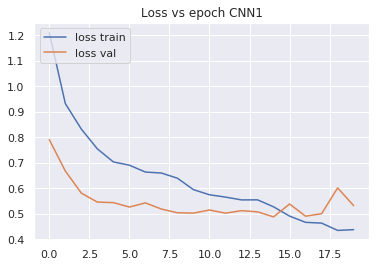

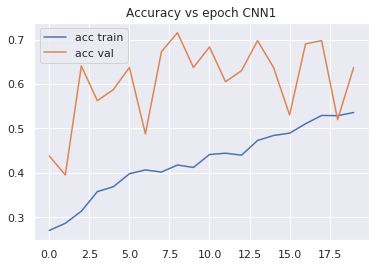


------ Training ------
Accuracy cnn1 : 0.7255781028787164
F1-score None cnn1 : [0.60746339 0.61538462 0.78487614 0.77804201]
F1-score macro cnn1 : 0.6964415403152138

------ Validation ------
Accuracy cnn1 : 0.6370106761565836
F1-score None cnn1 : [0.53571429 0.42857143 0.61016949 0.70404984]
F1-score macro cnn1 : 0.5696262625119745

------ Testing ------
Accuracy cnn1 : 0.6493633692458374
F1-score None cnn1 : [0.19685039 0.16842105 0.5645933  0.76954178]
F1-score macro cnn1 : 0.4248516316858786


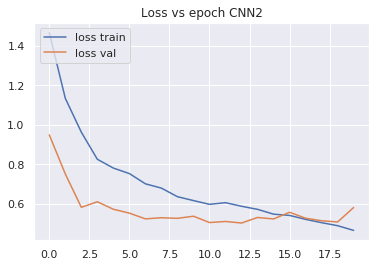


------ Training ------
Accuracy cnn2 : 0.5356300141576216
F1-score None cnn2 : [0.61620058 0.30288167 0.73566434 0.55276134]
F1-score macro cnn2 : 0.5518769807919606

------ Validation ------
Accuracy cnn2 : 0.5444839857651246
F1-score None cnn2 : [0.5875     0.19277108 0.64       0.60966543]
F1-score macro cnn2 : 0.5074841279616609

------ Testing ------
Accuracy cnn2 : 0.42605288932419194
F1-score None cnn2 : [0.18461538 0.17767654 0.56701031 0.55178416]
F1-score macro cnn2 : 0.37027159790460207


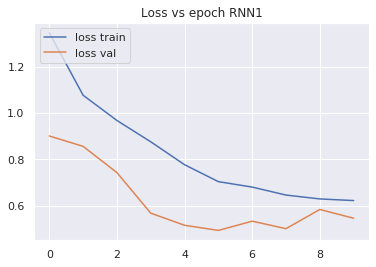

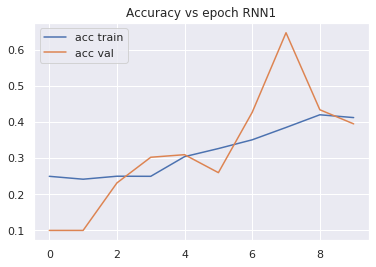


------ Training ------
Accuracy rnn1 : 0.3914582350165172
F1-score None rnn1 : [0.53957997 0.18146718 0.2587832  0.42951951]
F1-score macro rnn1 : 0.35233746637582086

------ Validation ------
Accuracy rnn1 : 0.39501779359430605
F1-score None rnn1 : [0.58064516 0.2        0.3253012  0.33484163]
F1-score macro rnn1 : 0.3601969987672189

------ Testing ------
Accuracy rnn1 : 0.3418217433888345
F1-score None rnn1 : [0.20560748 0.01923077 0.3        0.42911877]
F1-score macro rnn1 : 0.23848925495316087


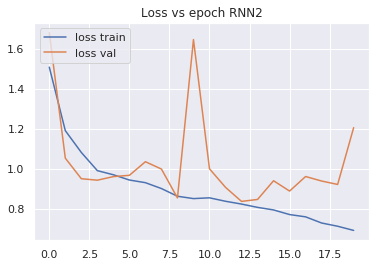

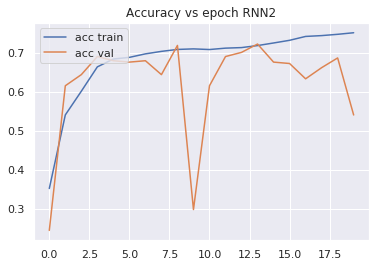


------ Training ------
Accuracy rnn2 : 0.5821142048135913
F1-score None rnn2 : [0.71866667 0.26737968 0.32875264 0.68184833]
F1-score macro rnn2 : 0.4991618298177768

------ Validation ------
Accuracy rnn2 : 0.5409252669039146
F1-score None rnn2 : [0.62686567 0.17391304 0.40625    0.59205776]
F1-score macro rnn2 : 0.44977161921322595

------ Testing ------
Accuracy rnn2 : 0.5161606268364348
F1-score None rnn2 : [0.09448819 0.13740458 0.3709369  0.65820777]
F1-score macro rnn2 : 0.3152593608061357


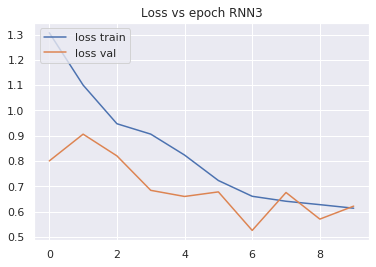

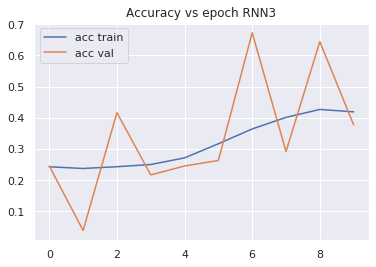


------ Training ------
Accuracy rnn3 : 0.3478055686644644
F1-score None rnn3 : [0.56723716 0.18487395 0.29098156 0.33881952]
F1-score macro rnn3 : 0.3454780502967977

------ Validation ------
Accuracy rnn3 : 0.37722419928825623
F1-score None rnn3 : [0.61428571 0.10526316 0.36986301 0.30136986]
F1-score macro rnn3 : 0.34769543722319496

------ Testing ------
Accuracy rnn3 : 0.31831537708129287
F1-score None rnn3 : [0.26027397 0.13375796 0.33719008 0.37461617]
F1-score macro rnn3 : 0.2764595472464429

Entrenando exec  2 



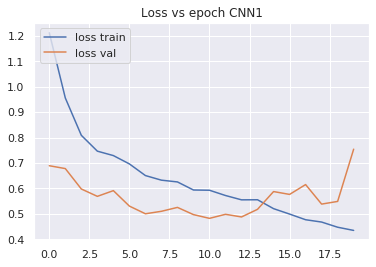

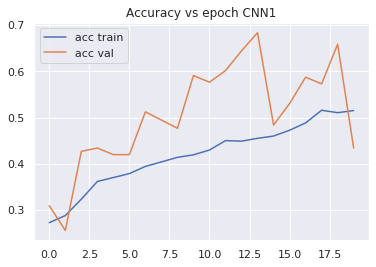


------ Training ------
Accuracy cnn1 : 0.5417649834827749
F1-score None cnn1 : [0.49822064 0.61772853 0.68666667 0.53999508]
F1-score macro cnn1 : 0.5856527291552343

------ Validation ------
Accuracy cnn1 : 0.43416370106761565
F1-score None cnn1 : [0.46280992 0.30769231 0.51162791 0.4063745 ]
F1-score macro cnn1 : 0.42212615850411395

------ Testing ------
Accuracy cnn1 : 0.41332027424094026
F1-score None cnn1 : [0.16135084 0.19310345 0.47852761 0.54288093]
F1-score macro cnn1 : 0.3439657081179255


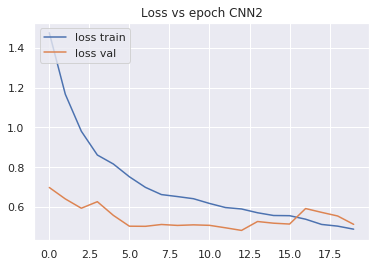

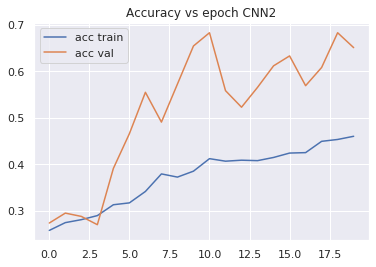


------ Training ------
Accuracy cnn2 : 0.6793298725814063
F1-score None cnn2 : [0.62380952 0.41980624 0.68618267 0.74486336]
F1-score macro cnn2 : 0.6186654480368421

------ Validation ------
Accuracy cnn2 : 0.6512455516014235
F1-score None cnn2 : [0.56060606 0.21621622 0.63492063 0.73939394]
F1-score macro cnn2 : 0.5377842127842127

------ Testing ------
Accuracy cnn2 : 0.6297747306562194
F1-score None cnn2 : [0.11180124 0.22907489 0.62447257 0.75370501]
F1-score macro cnn2 : 0.42976342913231835


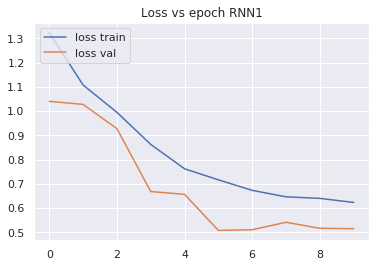

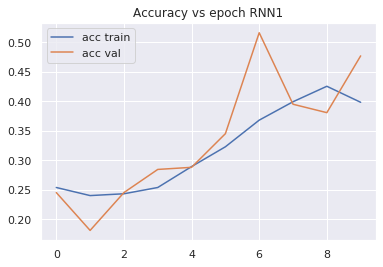


------ Training ------
Accuracy rnn1 : 0.42402076451156206
F1-score None rnn1 : [0.55244371 0.18859649 0.38526912 0.46090323]
F1-score macro rnn1 : 0.39680313777339293

------ Validation ------
Accuracy rnn1 : 0.47686832740213525
F1-score None rnn1 : [0.5751634  0.06153846 0.54166667 0.5       ]
F1-score macro rnn1 : 0.4195921317244847

------ Testing ------
Accuracy rnn1 : 0.4152791380999021
F1-score None rnn1 : [0.22335025 0.17804154 0.45517241 0.50885368]
F1-score macro rnn1 : 0.34135447297359767


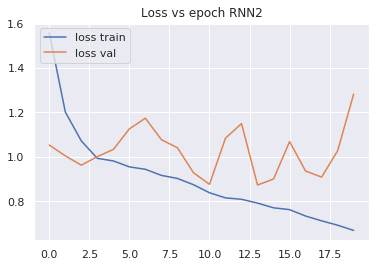

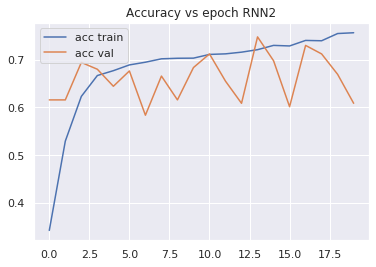


------ Training ------
Accuracy rnn2 : 0.6826333176026428
F1-score None rnn2 : [0.58752515 0.23444976 0.66193182 0.77264325]
F1-score macro rnn2 : 0.5641374957718879

------ Validation ------
Accuracy rnn2 : 0.608540925266904
F1-score None rnn2 : [0.53684211 0.13333333 0.66666667 0.66666667]
F1-score macro rnn2 : 0.5008771929824561

------ Testing ------
Accuracy rnn2 : 0.5386875612144956
F1-score None rnn2 : [0.15602837 0.05       0.56108597 0.68740516]
F1-score macro rnn2 : 0.36362987524433166


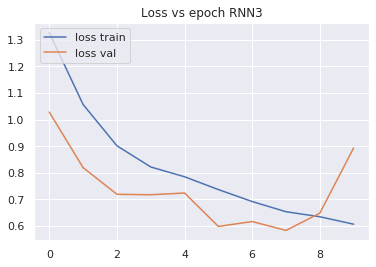

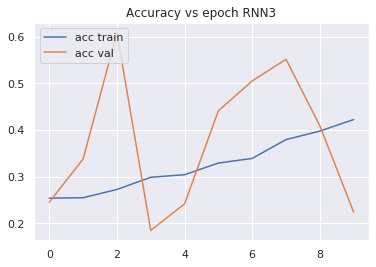


------ Training ------
Accuracy rnn3 : 0.15526191599811232
F1-score None rnn3 : [0.49394673 0.01179941 0.15924492 0.01518438]
F1-score macro rnn3 : 0.1700438601896248

------ Validation ------
Accuracy rnn3 : 0.22419928825622776
F1-score None rnn3 : [0.59130435 0.         0.21455939 0.01142857]
F1-score macro rnn3 : 0.20432307655695964

------ Testing ------
Accuracy rnn3 : 0.12438785504407443
F1-score None rnn3 : [0.09302326 0.         0.19413919 0.0427673 ]
F1-score macro rnn3 : 0.08248243638765797

Entrenando exec  3 



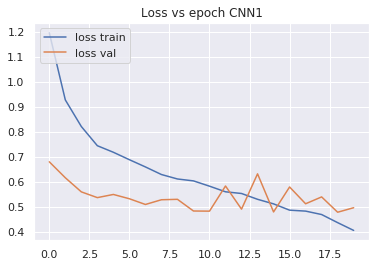

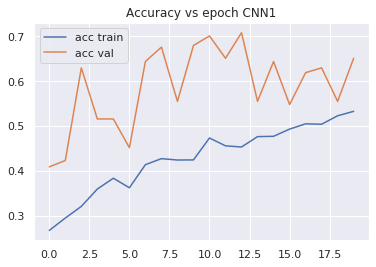


------ Training ------
Accuracy cnn1 : 0.697262859839547
F1-score None cnn1 : [0.60205832 0.56321839 0.77001271 0.74581179]
F1-score macro cnn1 : 0.670275301340654

------ Validation ------
Accuracy cnn1 : 0.6512455516014235
F1-score None cnn1 : [0.57303371 0.14285714 0.68965517 0.71153846]
F1-score macro cnn1 : 0.5292711211686415

------ Testing ------
Accuracy cnn1 : 0.6072477962781586
F1-score None cnn1 : [0.17665615 0.15053763 0.57918552 0.73848335]
F1-score macro cnn1 : 0.4112156628338597


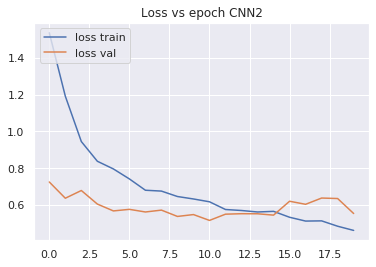

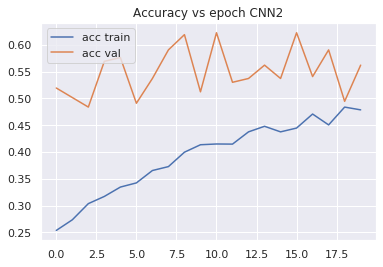


------ Training ------
Accuracy cnn2 : 0.5752713544124587
F1-score None cnn2 : [0.51880492 0.29176471 0.73965287 0.6107247 ]
F1-score macro cnn2 : 0.5402368000012648

------ Validation ------
Accuracy cnn2 : 0.5622775800711743
F1-score None cnn2 : [0.51960784 0.125      0.60714286 0.60839161]
F1-score macro cnn2 : 0.4650355771679301

------ Testing ------
Accuracy cnn2 : 0.5132223310479922
F1-score None cnn2 : [0.18987342 0.12048193 0.60869565 0.64319249]
F1-score macro cnn2 : 0.39056087146729657


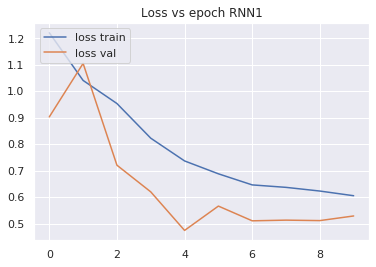

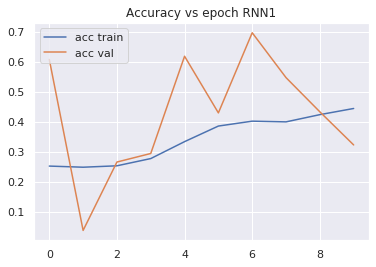


------ Training ------
Accuracy rnn1 : 0.2800849457291175
F1-score None rnn1 : [0.44436837 0.18421053 0.40764331 0.10644831]
F1-score macro rnn1 : 0.28566762914297644

------ Validation ------
Accuracy rnn1 : 0.3238434163701068
F1-score None rnn1 : [0.49541284 0.11428571 0.53763441 0.08839779]
F1-score macro rnn1 : 0.3089326892449527

------ Testing ------
Accuracy rnn1 : 0.197845249755142
F1-score None rnn1 : [0.17695473 0.16022099 0.49867374 0.08812729]
F1-score macro rnn1 : 0.2309941905050292


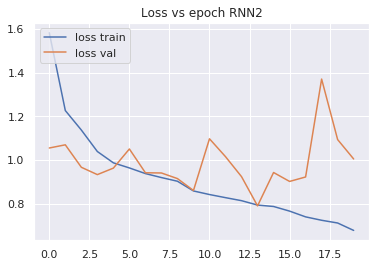

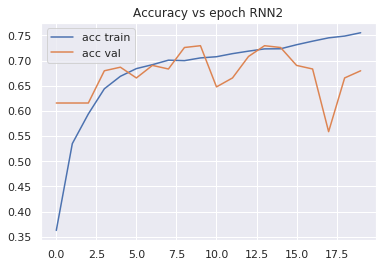


------ Training ------
Accuracy rnn2 : 0.7708824917413875
F1-score None rnn2 : [0.72715736 0.11458333 0.56864865 0.86174209]
F1-score macro rnn2 : 0.5680328569706545

------ Validation ------
Accuracy rnn2 : 0.6797153024911032
F1-score None rnn2 : [0.62318841 0.         0.58227848 0.75757576]
F1-score macro rnn2 : 0.49076066109637934

------ Testing ------
Accuracy rnn2 : 0.6650342801175319
F1-score None rnn2 : [0.17777778 0.         0.47686833 0.79202658]
F1-score macro rnn2 : 0.36166817081325064



------ Training ------
Accuracy rnn3 : 0.3114676734308636
F1-score None rnn3 : [0.56645161 0.17258883 0.3424821  0.25853659]
F1-score macro rnn3 : 0.3350147827487631

------ Validation ------
Accuracy rnn3 : 0.35587188612099646
F1-score None rnn3 : [0.57777778 0.08333333 0.43548387 0.28985507]
F1-score macro rnn3 : 0.34661251363565526

------ Testing ------
Accuracy rnn3 : 0.29285014691478944
F1-score None rnn3 : [0.26277372 0.14373717 0.42650104 0.30588235]
F1-score macro rnn3 : 0.2847235692725091

Entrenando exec  4 



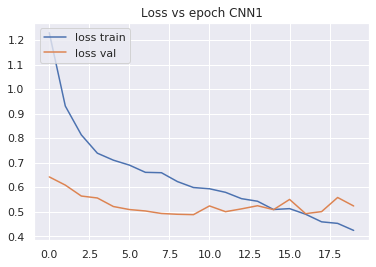


------ Training ------
Accuracy cnn1 : 0.6890042472864559
F1-score None cnn1 : [0.63651407 0.48942598 0.72750317 0.74288056]
F1-score macro cnn1 : 0.6490809431973171

------ Validation ------
Accuracy cnn1 : 0.6334519572953736
F1-score None cnn1 : [0.55555556 0.2        0.6875     0.7133758 ]
F1-score macro cnn1 : 0.5391078379334748

------ Testing ------
Accuracy cnn1 : 0.643486777668952
F1-score None cnn1 : [0.11842105 0.22522523 0.59360731 0.77018634]
F1-score macro cnn1 : 0.42685997979915097


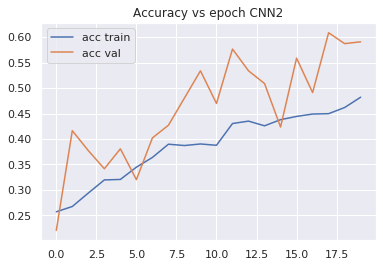


------ Training ------
Accuracy cnn2 : 0.6321378008494573
F1-score None cnn2 : [0.59309718 0.46516393 0.73453608 0.66961521]
F1-score macro cnn2 : 0.6156031039462875

------ Validation ------
Accuracy cnn2 : 0.5907473309608541
F1-score None cnn2 : [0.57142857 0.17021277 0.66666667 0.65517241]
F1-score macro cnn2 : 0.5158701044614471

------ Testing ------
Accuracy cnn2 : 0.5719882468168462
F1-score None cnn2 : [0.20863309 0.21645022 0.63809524 0.69992441]
F1-score macro cnn2 : 0.44077574057019075


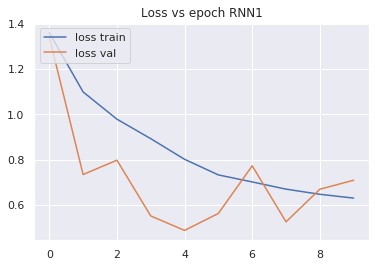

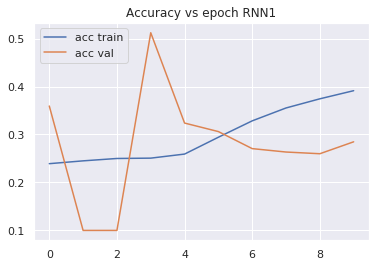


------ Training ------
Accuracy rnn1 : 0.21802737140160453
F1-score None rnn1 : [0.56518771 0.08627451 0.18383608 0.11047874]
F1-score macro rnn1 : 0.23644426214022768

------ Validation ------
Accuracy rnn1 : 0.2846975088967972
F1-score None rnn1 : [0.60150376 0.11764706 0.24215247 0.12698413]
F1-score macro rnn1 : 0.2720718528934664

------ Testing ------
Accuracy rnn1 : 0.1665034280117532
F1-score None rnn1 : [0.15652174 0.05357143 0.21560575 0.12604043]
F1-score macro rnn1 : 0.13793483631258685


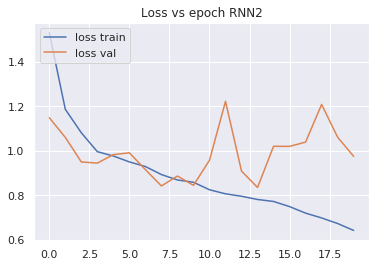


------ Training ------
Accuracy rnn2 : 0.7708824917413875
F1-score None rnn2 : [0.67070401 0.05780347 0.61403509 0.85942004]
F1-score macro rnn2 : 0.5504906530324106

------ Validation ------
Accuracy rnn2 : 0.6654804270462633
F1-score None rnn2 : [0.56896552 0.         0.48101266 0.75842697]
F1-score macro rnn2 : 0.45210128544034056

------ Testing ------
Accuracy rnn2 : 0.7218413320274241
F1-score None rnn2 : [0.12631579 0.         0.47586207 0.83427851]
F1-score macro rnn2 : 0.35911409283916396



------ Training ------
Accuracy rnn3 : 0.25955639452571966
F1-score None rnn3 : [0.4609484  0.13614263 0.35760728 0.05641749]
F1-score macro rnn3 : 0.2527789483272488

------ Validation ------
Accuracy rnn3 : 0.3096085409252669
F1-score None rnn3 : [0.5046729  0.12307692 0.48598131 0.03409091]
F1-score macro rnn3 : 0.28695550944382725

------ Testing ------
Accuracy rnn3 : 0.178256611165524
F1-score None rnn3 : [0.18454936 0.15249267 0.41935484 0.05493134]
F1-score macro rnn3 : 0.20283204984619163

Entrenando exec  5 



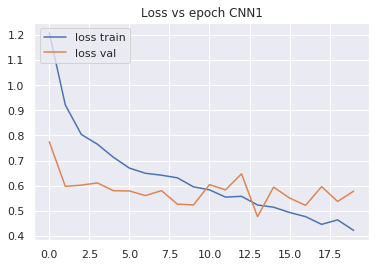


------ Training ------
Accuracy cnn1 : 0.6016989145823501
F1-score None cnn1 : [0.52594915 0.58680556 0.77333333 0.62700965]
F1-score macro cnn1 : 0.6282744204574853

------ Validation ------
Accuracy cnn1 : 0.5195729537366548
F1-score None cnn1 : [0.50228311 0.27272727 0.6        0.53874539]
F1-score macro cnn1 : 0.47843894130099457

------ Testing ------
Accuracy cnn1 : 0.5014691478942214
F1-score None cnn1 : [0.17316017 0.14285714 0.5483871  0.63888889]
F1-score macro cnn1 : 0.3758233254200996


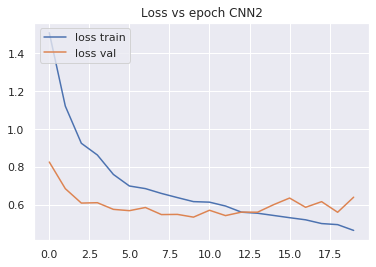

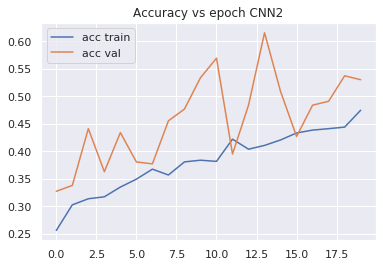


------ Training ------
Accuracy cnn2 : 0.6014629542236904
F1-score None cnn2 : [0.5741587  0.45845272 0.64774624 0.64390685]
F1-score macro cnn2 : 0.5810661300342914

------ Validation ------
Accuracy cnn2 : 0.5302491103202847
F1-score None cnn2 : [0.52631579 0.23529412 0.57777778 0.57971014]
F1-score macro cnn2 : 0.47977445745651426

------ Testing ------
Accuracy cnn2 : 0.5004897159647405
F1-score None cnn2 : [0.2        0.20849421 0.5060241  0.64246251]
F1-score macro cnn2 : 0.38924520368639387


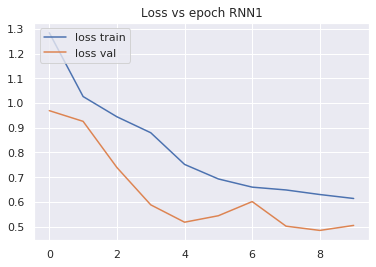

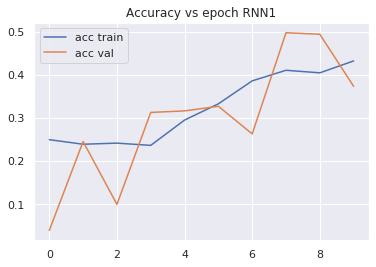


------ Training ------
Accuracy rnn1 : 0.31949032562529495
F1-score None rnn1 : [0.50882752 0.17537313 0.49450549 0.23591659]
F1-score macro rnn1 : 0.35365568536450703

------ Validation ------
Accuracy rnn1 : 0.3736654804270463
F1-score None rnn1 : [0.5433526  0.07142857 0.71428571 0.28019324]
F1-score macro rnn1 : 0.4023150308963327

------ Testing ------
Accuracy rnn1 : 0.29187071498530853
F1-score None rnn1 : [0.20863309 0.1821366  0.61090909 0.28976035]
F1-score macro rnn1 : 0.3228597838674969



------ Training ------
Accuracy rnn2 : 0.7402076451156205
F1-score None rnn2 : [0.63940943 0.21315193 0.50497018 0.83174493]
F1-score macro rnn2 : 0.5473191160951609

------ Validation ------
Accuracy rnn2 : 0.6548042704626335
F1-score None rnn2 : [0.52229299 0.         0.60869565 0.74351585]
F1-score macro rnn2 : 0.4686261239871446

------ Testing ------
Accuracy rnn2 : 0.6767874632713027
F1-score None rnn2 : [0.13157895 0.10526316 0.44444444 0.81353768]
F1-score macro rnn2 : 0.37370605632856085


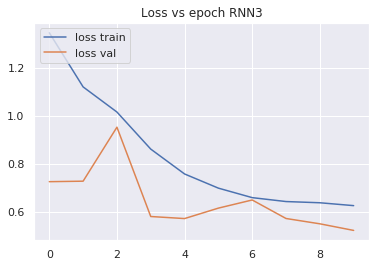

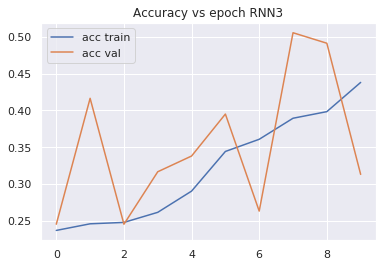


------ Training ------
Accuracy rnn3 : 0.255545068428504
F1-score None rnn3 : [0.4876668  0.14914312 0.47740668 0.05378627]
F1-score macro rnn3 : 0.2920007183456002

------ Validation ------
Accuracy rnn3 : 0.31316725978647686
F1-score None rnn3 : [0.54054054 0.06956522 0.65       0.08791209]
F1-score macro rnn3 : 0.33700446146098323

------ Testing ------
Accuracy rnn3 : 0.1929480901077375
F1-score None rnn3 : [0.20454545 0.15120275 0.60983607 0.05977584]
F1-score macro rnn3 : 0.25634002746446927


In [14]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=10, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=10, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [15]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("Original - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("Original - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("Original - Accuracy promedio para",key,":" ,temp/5)

Original - F1-score promedio para cnn1 : [0.16528772 0.1760289  0.55286017 0.69199626]
Original - F1-score promedio para cnn2 : [0.17898463 0.19043556 0.58885957 0.65821372]
Original - F1-score promedio para rnn1 : [0.19421346 0.11864027 0.4160722  0.28838011]
Original - F1-score promedio para rnn2 : [0.13723781 0.05853355 0.46583954 0.75709114]
Original - F1-score promedio para rnn3 : [0.20103315 0.11623811 0.39740424 0.1675946 ]

Original - F1-score macro promedio para cnn1 : 0.39654326157138287 desvest:  0.032029553424026115
Original - F1-score macro promedio para cnn2 : 0.4041233685521603 desvest:  0.026653527248854048
Original - F1-score macro promedio para rnn1 : 0.2543265077223743 desvest:  0.07295603258199077
Original - F1-score macro promedio para rnn2 : 0.35467551120628854 desvest:  0.02032030260913774
Original - F1-score macro promedio para rnn3 : 0.22056752604345417 desvest:  0.07470157545336399

Original - Accuracy promedio para cnn1 : 0.562977473065622
Original - Accuracy

### Aumento no Ponderado - Clase

In [16]:
macro_augmented = np.load('../Datasets/CSV_Stance/balance_clase_noPon.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



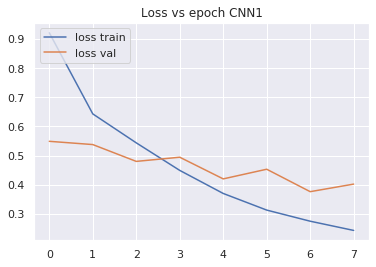


------ Training ------
Accuracy cnn1 : 0.8939283101682517
F1-score None cnn1 : [0.86422303 0.9528757  0.96529401 0.78786693]
F1-score macro cnn1 : 0.8925649151227534

------ Validation ------
Accuracy cnn1 : 0.6690391459074733
F1-score None cnn1 : [0.57317073 0.30769231 0.67857143 0.74683544]
F1-score macro cnn1 : 0.5765674777522569

------ Testing ------
Accuracy cnn1 : 0.6405484818805093
F1-score None cnn1 : [0.22053232 0.25899281 0.59813084 0.76157083]
F1-score macro cnn1 : 0.4598066984395017


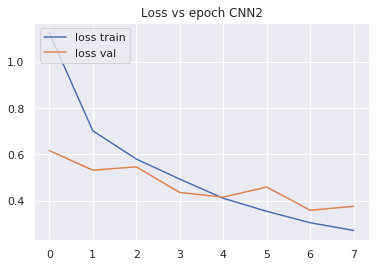

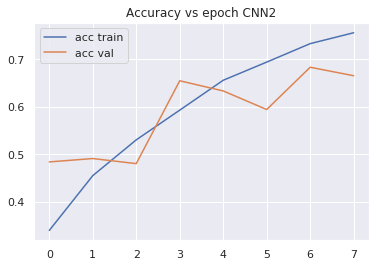


------ Training ------
Accuracy cnn2 : 0.8489392831016825
F1-score None cnn2 : [0.81939969 0.90765588 0.95058031 0.72920036]
F1-score macro cnn2 : 0.851709060295445

------ Validation ------
Accuracy cnn2 : 0.6654804270462633
F1-score None cnn2 : [0.56470588 0.35294118 0.6        0.74461538]
F1-score macro cnn2 : 0.5655656108597285

------ Testing ------
Accuracy cnn2 : 0.6660137120470128
F1-score None cnn2 : [0.25441696 0.04878049 0.51162791 0.79468439]
F1-score macro cnn2 : 0.40237743532360604


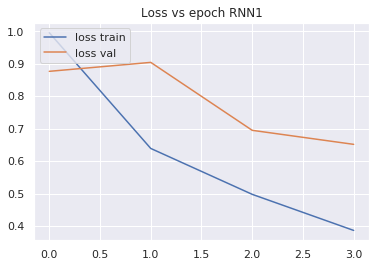

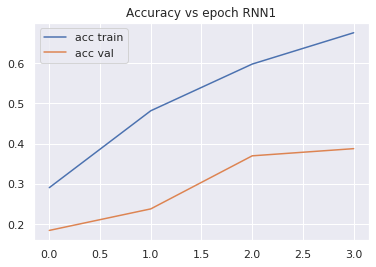


------ Training ------
Accuracy rnn1 : 0.5676664228237015
F1-score None rnn1 : [0.62260393 0.58387236 0.68617512 0.35555556]
F1-score macro rnn1 : 0.562051740705452

------ Validation ------
Accuracy rnn1 : 0.3879003558718861
F1-score None rnn1 : [0.49361702 0.11538462 0.42857143 0.33476395]
F1-score macro rnn1 : 0.3430842534326234

------ Testing ------
Accuracy rnn1 : 0.33104799216454456
F1-score None rnn1 : [0.19389587 0.15564202 0.42038217 0.43137255]
F1-score macro rnn1 : 0.30032315217677324


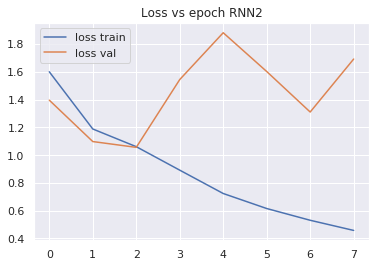

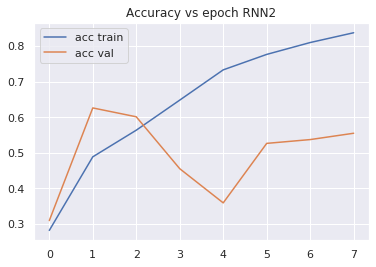


------ Training ------
Accuracy rnn2 : 0.8348573518653987
F1-score None rnn2 : [0.7226776  0.88966318 0.9507772  0.75814184]
F1-score macro rnn2 : 0.8303149554184446

------ Validation ------
Accuracy rnn2 : 0.5551601423487544
F1-score None rnn2 : [0.45714286 0.17582418 0.44       0.71518987]
F1-score macro rnn2 : 0.4470392265961886

------ Testing ------
Accuracy rnn2 : 0.6346718903036239
F1-score None rnn2 : [0.10416667 0.1971831  0.44897959 0.77899045]
F1-score macro rnn2 : 0.3823299518248973


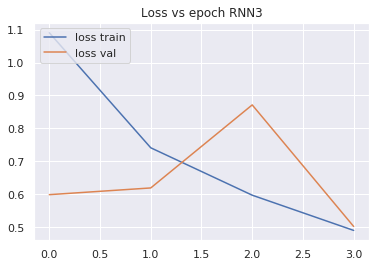

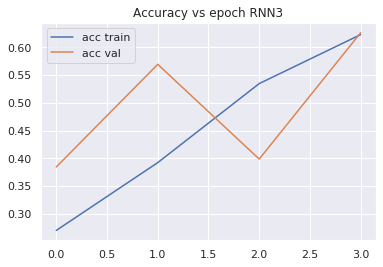


------ Training ------
Accuracy rnn3 : 0.5900694952450621
F1-score None rnn3 : [0.68721416 0.24070022 0.69283322 0.56772941]
F1-score macro rnn3 : 0.5471192511141709

------ Validation ------
Accuracy rnn3 : 0.6263345195729537
F1-score None rnn3 : [0.60992908 0.         0.50980392 0.70394737]
F1-score macro rnn3 : 0.45592009200096617

------ Testing ------
Accuracy rnn3 : 0.5954946131243879
F1-score None rnn3 : [0.24358974 0.075      0.4043956  0.73131014]
F1-score macro rnn3 : 0.3635738721554784

Entrenando exec  2 



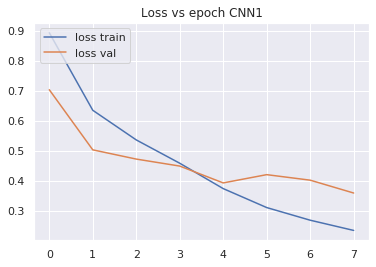

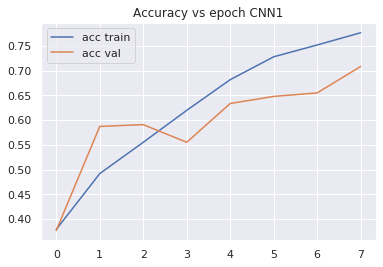


------ Training ------
Accuracy cnn1 : 0.8929224579370885
F1-score None cnn1 : [0.85086455 0.95170613 0.96675099 0.80250784]
F1-score macro cnn1 : 0.8929573796967551

------ Validation ------
Accuracy cnn1 : 0.708185053380783
F1-score None cnn1 : [0.58108108 0.36363636 0.71186441 0.78678679]
F1-score macro cnn1 : 0.6108421595709731

------ Testing ------
Accuracy cnn1 : 0.6904995102840352
F1-score None cnn1 : [0.20512821 0.2295082  0.57276995 0.80687831]
F1-score macro cnn1 : 0.45357116544486664


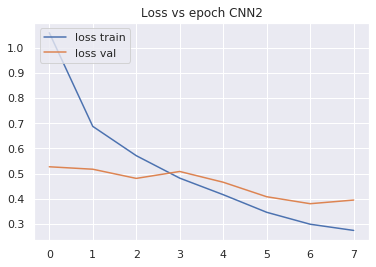

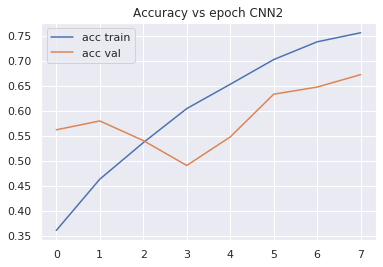


------ Training ------
Accuracy cnn2 : 0.7680138990490124
F1-score None cnn2 : [0.80654039 0.68208092 0.93114002 0.65178147]
F1-score macro cnn2 : 0.7678857011544347

------ Validation ------
Accuracy cnn2 : 0.6725978647686833
F1-score None cnn2 : [0.59302326 0.         0.57777778 0.74850299]
F1-score macro cnn2 : 0.4798260069009268

------ Testing ------
Accuracy cnn2 : 0.6366307541625857
F1-score None cnn2 : [0.1980198  0.07792208 0.45398773 0.77384923]
F1-score macro cnn2 : 0.3759447106963767


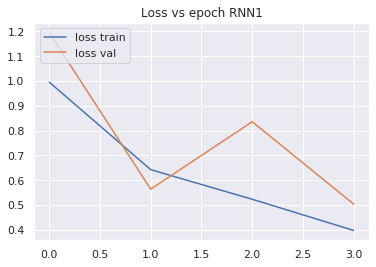

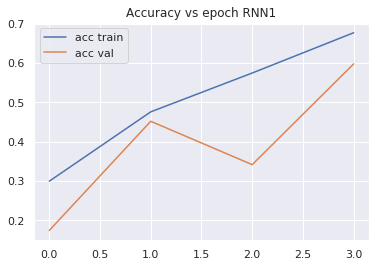


------ Training ------
Accuracy rnn1 : 0.7477139722019019
F1-score None rnn1 : [0.72065776 0.74871795 0.86902219 0.64319891]
F1-score macro rnn1 : 0.7453992000709944

------ Validation ------
Accuracy rnn1 : 0.597864768683274
F1-score None rnn1 : [0.56923077 0.2        0.44736842 0.69620253]
F1-score macro rnn1 : 0.47820043048224264

------ Testing ------
Accuracy rnn1 : 0.6180215475024485
F1-score None rnn1 : [0.2        0.29145729 0.45768025 0.74421965]
F1-score macro rnn1 : 0.42333929759876265


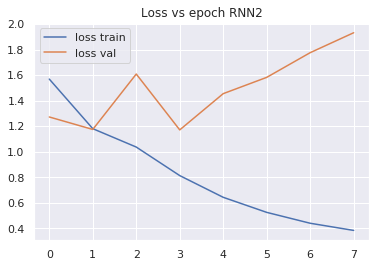

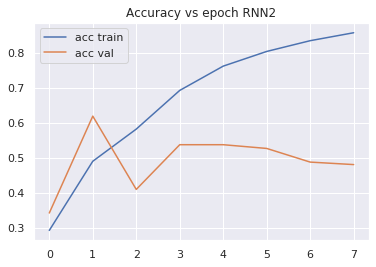


------ Training ------
Accuracy rnn2 : 0.856528895391368
F1-score None rnn2 : [0.82639561 0.94115562 0.95057168 0.66666667]
F1-score macro rnn2 : 0.8461973941471238

------ Validation ------
Accuracy rnn2 : 0.4804270462633452
F1-score None rnn2 : [0.50273224 0.18867925 0.42253521 0.54117647]
F1-score macro rnn2 : 0.4137807918940046

------ Testing ------
Accuracy rnn2 : 0.4681684622918707
F1-score None rnn2 : [0.16393443 0.25116279 0.47328244 0.59883236]
F1-score macro rnn2 : 0.3718030049938811


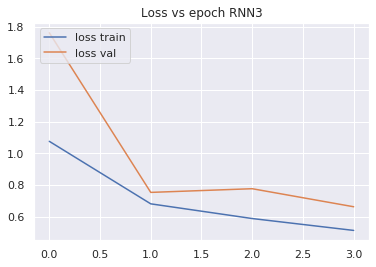

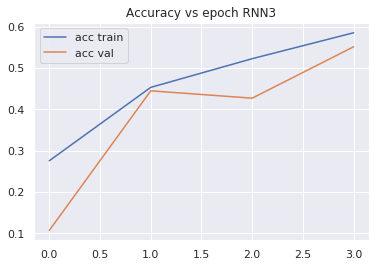


------ Training ------
Accuracy rnn3 : 0.5504754937820044
F1-score None rnn3 : [0.68614673 0.21823899 0.61775701 0.51981395]
F1-score macro rnn3 : 0.5104891719194814

------ Validation ------
Accuracy rnn3 : 0.5516014234875445
F1-score None rnn3 : [0.6119403  0.19047619 0.39370079 0.62142857]
F1-score macro rnn3 : 0.4543864619534499

------ Testing ------
Accuracy rnn3 : 0.5181194906953966
F1-score None rnn3 : [0.24637681 0.08695652 0.34662045 0.66072874]
F1-score macro rnn3 : 0.3351706322197976

Entrenando exec  3 



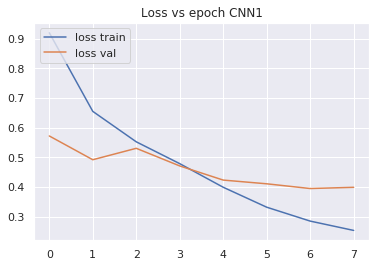

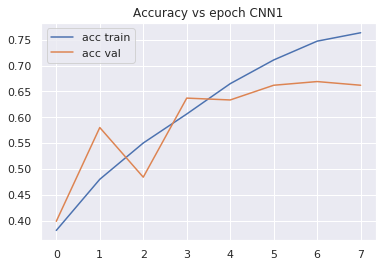


------ Training ------
Accuracy cnn1 : 0.875
F1-score None cnn1 : [0.84251305 0.93704191 0.96478873 0.75584515]
F1-score macro cnn1 : 0.8750472117349334

------ Validation ------
Accuracy cnn1 : 0.6619217081850534
F1-score None cnn1 : [0.58682635 0.34782609 0.54545455 0.73780488]
F1-score macro cnn1 : 0.5544779644413091

------ Testing ------
Accuracy cnn1 : 0.6297747306562194
F1-score None cnn1 : [0.1484375  0.23880597 0.45508982 0.76767677]
F1-score macro cnn1 : 0.4025025145463257


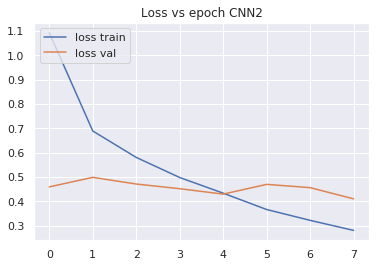

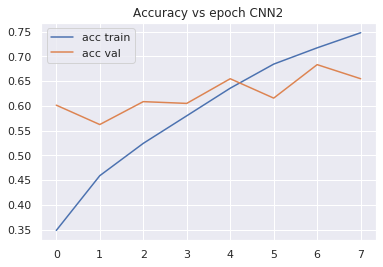


------ Training ------
Accuracy cnn2 : 0.8536942209217264
F1-score None cnn2 : [0.77829196 0.92190544 0.95979532 0.75245874]
F1-score macro cnn2 : 0.8531128664843957

------ Validation ------
Accuracy cnn2 : 0.6548042704626335
F1-score None cnn2 : [0.51724138 0.26666667 0.60377358 0.75862069]
F1-score macro cnn2 : 0.5365755801344612

------ Testing ------
Accuracy cnn2 : 0.6944172380019589
F1-score None cnn2 : [0.0990099  0.21212121 0.54255319 0.81286174]
F1-score macro cnn2 : 0.41663651023376946


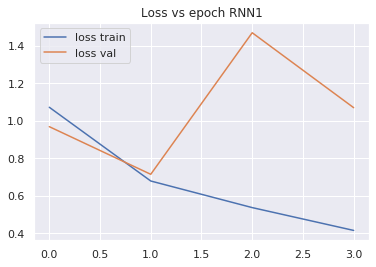

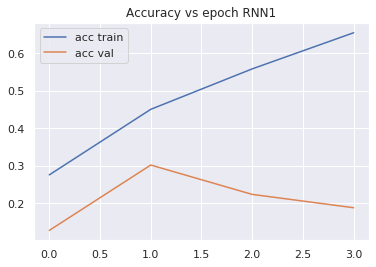


------ Training ------
Accuracy rnn1 : 0.4948792977322604
F1-score None rnn1 : [0.69666374 0.51370251 0.52948751 0.05541915]
F1-score macro rnn1 : 0.44881822866448406

------ Validation ------
Accuracy rnn1 : 0.18861209964412812
F1-score None rnn1 : [0.45614035 0.08181818 0.46808511 0.07734807]
F1-score macro rnn1 : 0.270847926344174

------ Testing ------
Accuracy rnn1 : 0.12438785504407443
F1-score None rnn1 : [0.23129252 0.13844515 0.34615385 0.045     ]
F1-score macro rnn1 : 0.19022287939506105


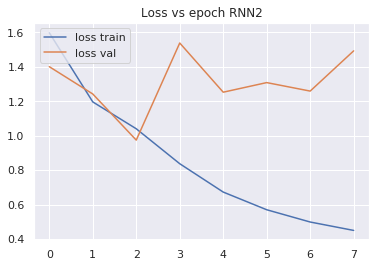

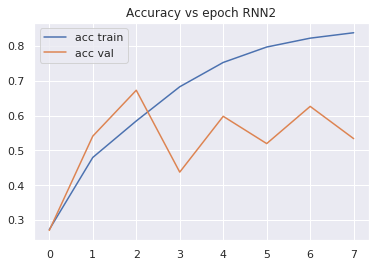


------ Training ------
Accuracy rnn2 : 0.8733540599853694
F1-score None rnn2 : [0.82724742 0.94978006 0.96001434 0.74260355]
F1-score macro rnn2 : 0.8699113436422294

------ Validation ------
Accuracy rnn2 : 0.5338078291814946
F1-score None rnn2 : [0.48618785 0.18181818 0.53571429 0.61921708]
F1-score macro rnn2 : 0.45573434867171714

------ Testing ------
Accuracy rnn2 : 0.534769833496572
F1-score None rnn2 : [0.19786096 0.18181818 0.47577093 0.68531469]
F1-score macro rnn2 : 0.38519118870246105


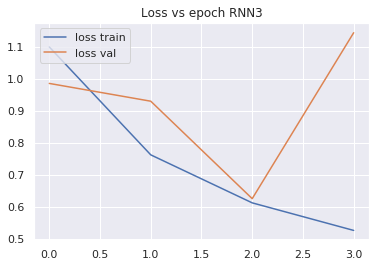

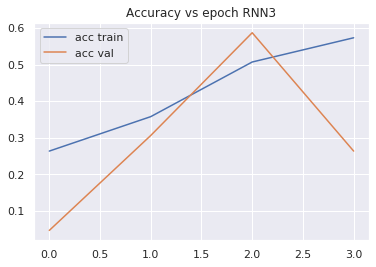


------ Training ------
Accuracy rnn3 : 0.4442209217264082
F1-score None rnn3 : [0.67287647 0.21929101 0.51398866 0.14185751]
F1-score macro rnn3 : 0.38700341187620196

------ Validation ------
Accuracy rnn3 : 0.26334519572953735
F1-score None rnn3 : [0.47457627 0.12903226 0.24545455 0.1761658 ]
F1-score macro rnn3 : 0.2563072194535776

------ Testing ------
Accuracy rnn3 : 0.1821743388834476
F1-score None rnn3 : [0.2295082  0.0729927  0.22198506 0.14893617]
F1-score macro rnn3 : 0.16835553159049418

Entrenando exec  4 



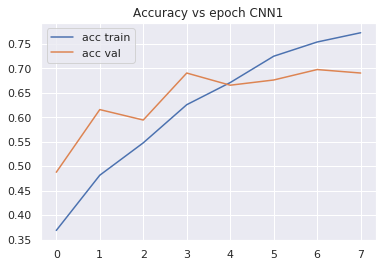


------ Training ------
Accuracy cnn1 : 0.8804864667154353
F1-score None cnn1 : [0.85522465 0.93363932 0.95827925 0.77926852]
F1-score macro cnn1 : 0.881602934570504

------ Validation ------
Accuracy cnn1 : 0.6903914590747331
F1-score None cnn1 : [0.59493671 0.375      0.6122449  0.76106195]
F1-score macro cnn1 : 0.5858108884306494

------ Testing ------
Accuracy cnn1 : 0.6650342801175319
F1-score None cnn1 : [0.24710425 0.12631579 0.5136612  0.78936877]
F1-score macro cnn1 : 0.41911250238196085


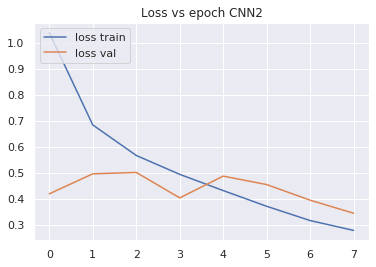

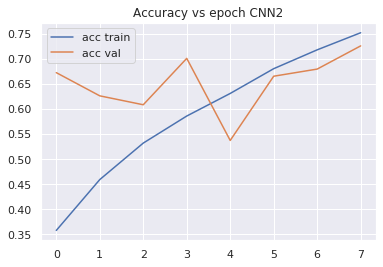


------ Training ------
Accuracy cnn2 : 0.8521397220190198
F1-score None cnn2 : [0.8489105  0.85531476 0.96898513 0.74688797]
F1-score macro cnn2 : 0.855024589500879

------ Validation ------
Accuracy cnn2 : 0.7259786476868327
F1-score None cnn2 : [0.62162162 0.28571429 0.60869565 0.80225989]
F1-score macro cnn2 : 0.5795728616288676

------ Testing ------
Accuracy cnn2 : 0.702252693437806
F1-score None cnn2 : [0.24884793 0.10126582 0.47953216 0.81904762]
F1-score macro cnn2 : 0.41217338296060013


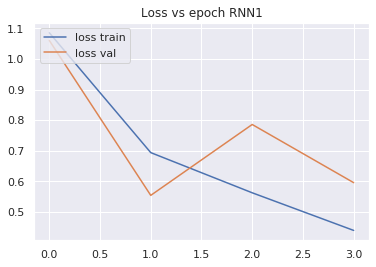


------ Training ------
Accuracy rnn1 : 0.6968727139722019
F1-score None rnn1 : [0.5747992  0.73161414 0.85750916 0.59778718]
F1-score macro rnn1 : 0.6904274171436713

------ Validation ------
Accuracy rnn1 : 0.5587188612099644
F1-score None rnn1 : [0.44230769 0.15       0.53333333 0.70440252]
F1-score macro rnn1 : 0.45751088534107404

------ Testing ------
Accuracy rnn1 : 0.5905974534769833
F1-score None rnn1 : [0.04494382 0.21787709 0.56637168 0.72753835]
F1-score macro rnn1 : 0.38918273644317153


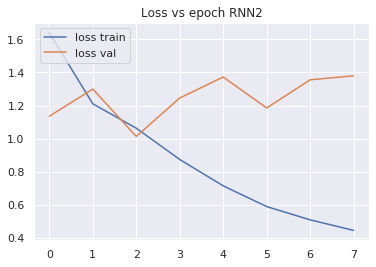


------ Training ------
Accuracy rnn2 : 0.8791148500365764
F1-score None rnn2 : [0.8126307  0.94388849 0.95150442 0.80150582]
F1-score macro rnn2 : 0.8773823582360142

------ Validation ------
Accuracy rnn2 : 0.597864768683274
F1-score None rnn2 : [0.52380952 0.22222222 0.5        0.7133758 ]
F1-score macro rnn2 : 0.4898518855525225

------ Testing ------
Accuracy rnn2 : 0.6777668952007836
F1-score None rnn2 : [0.0754717  0.23255814 0.49042146 0.80372588]
F1-score macro rnn2 : 0.4005442937892454


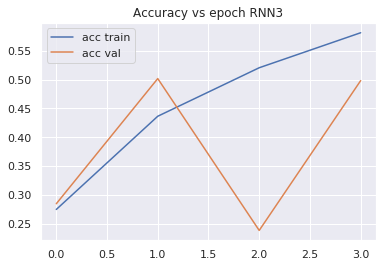


------ Training ------
Accuracy rnn3 : 0.6271031455742502
F1-score None rnn3 : [0.68330579 0.54422658 0.73786408 0.46639603]
F1-score macro rnn3 : 0.6079481182466616

------ Validation ------
Accuracy rnn3 : 0.498220640569395
F1-score None rnn3 : [0.56140351 0.20512821 0.4952381  0.50202429]
F1-score macro rnn3 : 0.44094852515905136

------ Testing ------
Accuracy rnn3 : 0.44172380019588636
F1-score None rnn3 : [0.22857143 0.21576763 0.43583535 0.54693141]
F1-score macro rnn3 : 0.35677645561450677

Entrenando exec  5 



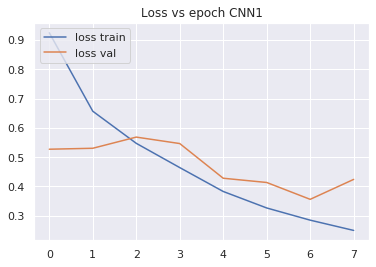

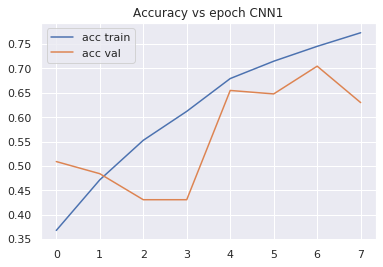


------ Training ------
Accuracy cnn1 : 0.8746342355523044
F1-score None cnn1 : [0.85300136 0.93490909 0.95452837 0.75318164]
F1-score macro cnn1 : 0.8739051177106111

------ Validation ------
Accuracy cnn1 : 0.6298932384341637
F1-score None cnn1 : [0.57309942 0.3030303  0.56521739 0.70512821]
F1-score macro cnn1 : 0.5366188286668836

------ Testing ------
Accuracy cnn1 : 0.5984329089128305
F1-score None cnn1 : [0.20640569 0.22340426 0.4556962  0.74204947]
F1-score macro cnn1 : 0.4068889054414092


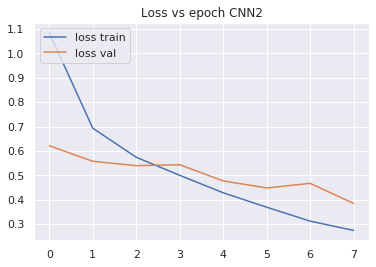

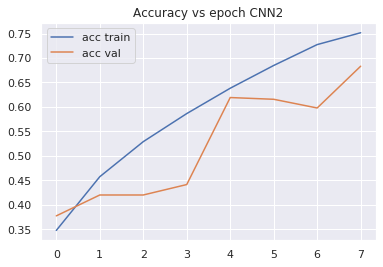


------ Training ------
Accuracy cnn2 : 0.8836869056327725
F1-score None cnn2 : [0.85117967 0.93820429 0.96098105 0.78568821]
F1-score macro cnn2 : 0.8840133044957713

------ Validation ------
Accuracy cnn2 : 0.6832740213523132
F1-score None cnn2 : [0.57718121 0.2962963  0.625      0.76923077]
F1-score macro cnn2 : 0.5669270683951892

------ Testing ------
Accuracy cnn2 : 0.6699314397649363
F1-score None cnn2 : [0.22330097 0.24050633 0.54255319 0.79328859]
F1-score macro cnn2 : 0.4499122705202748



------ Training ------
Accuracy rnn1 : 0.5377651792245793
F1-score None rnn1 : [0.62912806 0.3795243  0.59949064 0.46851385]
F1-score macro rnn1 : 0.5191642145325223

------ Validation ------
Accuracy rnn1 : 0.4128113879003559
F1-score None rnn1 : [0.44036697 0.13953488 0.32911392 0.5       ]
F1-score macro rnn1 : 0.35225394506215685

------ Testing ------
Accuracy rnn1 : 0.4250734573947111
F1-score None rnn1 : [0.24793388 0.10852713 0.29742033 0.55428067]
F1-score macro rnn1 : 0.30204050517628545


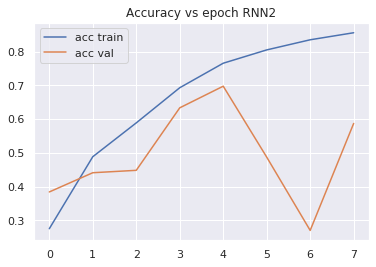


------ Training ------
Accuracy rnn2 : 0.8520482809070958
F1-score None rnn2 : [0.87834372 0.87661812 0.88154897 0.76821938]
F1-score macro rnn2 : 0.8511825493722547

------ Validation ------
Accuracy rnn2 : 0.5871886120996441
F1-score None rnn2 : [0.56578947 0.09090909 0.46666667 0.67114094]
F1-score macro rnn2 : 0.4486265427143209

------ Testing ------
Accuracy rnn2 : 0.6033300685602351
F1-score None rnn2 : [0.20560748 0.07207207 0.45121951 0.74298056]
F1-score macro rnn2 : 0.36796990561444587


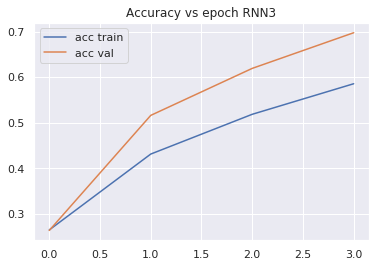


------ Training ------
Accuracy rnn3 : 0.5744330651060717
F1-score None rnn3 : [0.64371047 0.093361   0.79381268 0.5347738 ]
F1-score macro rnn3 : 0.516414487194375

------ Validation ------
Accuracy rnn3 : 0.697508896797153
F1-score None rnn3 : [0.57718121 0.15384615 0.67605634 0.7781155 ]
F1-score macro rnn3 : 0.5462998003619428

------ Testing ------
Accuracy rnn3 : 0.692458374142997
F1-score None rnn3 : [0.26530612 0.05405405 0.58085809 0.804629  ]
F1-score macro rnn3 : 0.42621181540771985


In [17]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [18]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase - Accuracy promedio para",key,":" ,temp/5)

0.15 Clase - F1-score promedio para cnn1 : [0.20552159 0.2154054  0.5190696  0.77350883]
0.15 Clase - F1-score promedio para cnn2 : [0.20471911 0.13611919 0.50605084 0.79874631]
0.15 Clase - F1-score promedio para rnn1 : [0.18361322 0.18238974 0.41760166 0.50048224]
0.15 Clase - F1-score promedio para rnn2 : [0.14940825 0.18695886 0.46793479 0.72196879]
0.15 Clase - F1-score promedio para rnn3 : [0.24267046 0.10095418 0.39793891 0.57850709]

0.15 Clase - F1-score macro promedio para cnn1 : 0.42837635725081286 desvest:  0.023831198189607224
0.15 Clase - F1-score macro promedio para cnn2 : 0.41140886194692544 desvest:  0.023873407639177818
0.15 Clase - F1-score macro promedio para rnn1 : 0.3210217141580108 desvest:  0.08125498726596159
0.15 Clase - F1-score macro promedio para rnn2 : 0.3815676689849862 desvest:  0.01143740434515603
0.15 Clase - F1-score macro promedio para rnn3 : 0.3300176613975994 desvest:  0.08632098810388644

0.15 Clase - Accuracy promedio para cnn1 : 0.64485798237022

In [19]:
macro_augmented = np.load('../Datasets/CSV_Stance/balance_clase_Pon.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



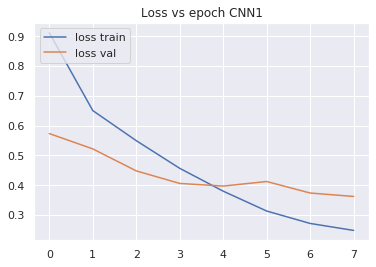

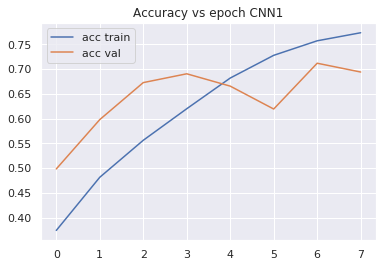


------ Training ------
Accuracy cnn1 : 0.841532553035845
F1-score None cnn1 : [0.83933184 0.8235547  0.96500182 0.74350321]
F1-score macro cnn1 : 0.8428478914521167

------ Validation ------
Accuracy cnn1 : 0.693950177935943
F1-score None cnn1 : [0.58227848 0.16666667 0.66666667 0.76744186]
F1-score macro cnn1 : 0.545763418702777

------ Testing ------
Accuracy cnn1 : 0.6885406464250735
F1-score None cnn1 : [0.23015873 0.02739726 0.55737705 0.81095176]
F1-score macro cnn1 : 0.40647119992933334


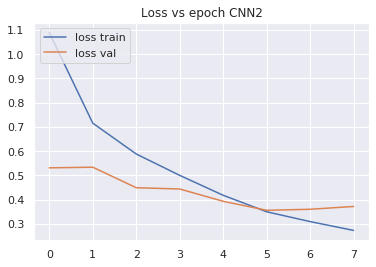


------ Training ------
Accuracy cnn2 : 0.8596378931967813
F1-score None cnn2 : [0.82171979 0.89351481 0.96451554 0.77106439]
F1-score macro cnn2 : 0.862703633386199

------ Validation ------
Accuracy cnn2 : 0.6797153024911032
F1-score None cnn2 : [0.54411765 0.35294118 0.54166667 0.76454294]
F1-score macro cnn2 : 0.5508171066210418

------ Testing ------
Accuracy cnn2 : 0.7257590597453477
F1-score None cnn2 : [0.16766467 0.1627907  0.5212766  0.83822611]
F1-score macro cnn2 : 0.42248951818996394


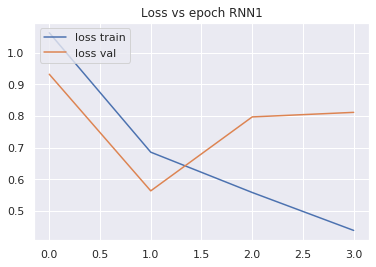

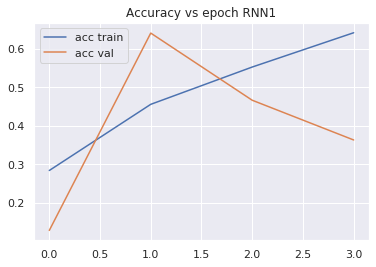


------ Training ------
Accuracy rnn1 : 0.5512070226773957
F1-score None rnn1 : [0.72915881 0.578354   0.34379671 0.43857635]
F1-score macro rnn1 : 0.5224714676964

------ Validation ------
Accuracy rnn1 : 0.36298932384341637
F1-score None rnn1 : [0.46376812 0.12676056 0.22222222 0.46341463]
F1-score macro rnn1 : 0.3190413839227186

------ Testing ------
Accuracy rnn1 : 0.346718903036239
F1-score None rnn1 : [0.23853211 0.17419355 0.26153846 0.47858473]
F1-score macro rnn1 : 0.2882122124996699


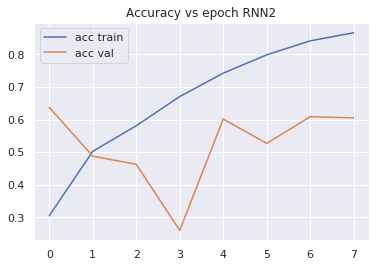


------ Training ------
Accuracy rnn2 : 0.7898683247988295
F1-score None rnn2 : [0.49300027 0.91249766 0.96697775 0.71338798]
F1-score macro rnn2 : 0.7714659140933888

------ Validation ------
Accuracy rnn2 : 0.604982206405694
F1-score None rnn2 : [0.32183908 0.18604651 0.4        0.75749319]
F1-score macro rnn2 : 0.416344695024644

------ Testing ------
Accuracy rnn2 : 0.7100881488736532
F1-score None rnn2 : [0.         0.15037594 0.43049327 0.82549505]
F1-score macro rnn2 : 0.3515910657242939


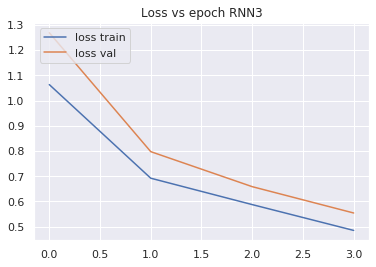

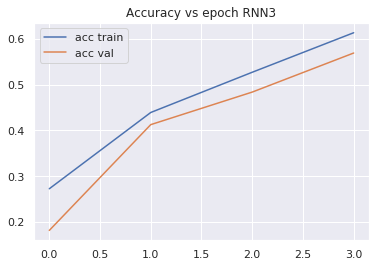


------ Training ------
Accuracy rnn3 : 0.7030907095830286
F1-score None rnn3 : [0.69025022 0.71623037 0.81769567 0.56757263]
F1-score macro rnn3 : 0.6979372222645002

------ Validation ------
Accuracy rnn3 : 0.5693950177935944
F1-score None rnn3 : [0.62318841 0.27118644 0.51219512 0.62190813]
F1-score macro rnn3 : 0.5071195239086919

------ Testing ------
Accuracy rnn3 : 0.5416258570029383
F1-score None rnn3 : [0.23287671 0.25316456 0.46987952 0.66987179]
F1-score macro rnn3 : 0.4064481455587191

Entrenando exec  2 



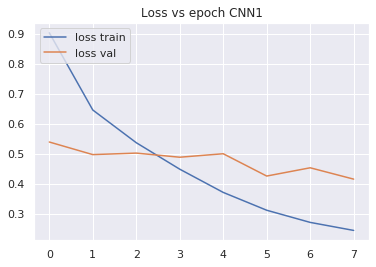

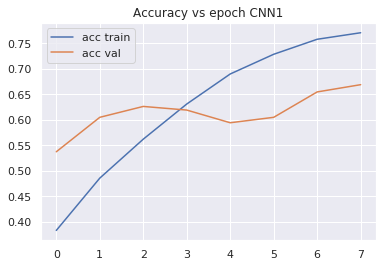


------ Training ------
Accuracy cnn1 : 0.84957937088515
F1-score None cnn1 : [0.83732619 0.8831643  0.95715896 0.73190586]
F1-score macro cnn1 : 0.8523888264149566

------ Validation ------
Accuracy cnn1 : 0.6690391459074733
F1-score None cnn1 : [0.58181818 0.375      0.43902439 0.75294118]
F1-score macro cnn1 : 0.5371959371331682

------ Testing ------
Accuracy cnn1 : 0.6474045053868757
F1-score None cnn1 : [0.20805369 0.1025641  0.5        0.77896138]
F1-score macro cnn1 : 0.3973947946648775


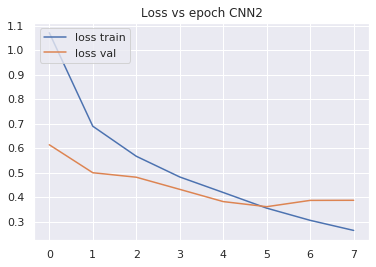

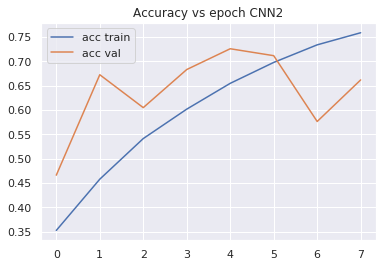


------ Training ------
Accuracy cnn2 : 0.8507681053401609
F1-score None cnn2 : [0.82786202 0.8854314  0.96399706 0.73201899]
F1-score macro cnn2 : 0.8523273673236641

------ Validation ------
Accuracy cnn2 : 0.6619217081850534
F1-score None cnn2 : [0.56470588 0.26666667 0.59574468 0.73939394]
F1-score macro cnn2 : 0.5416277923161528

------ Testing ------
Accuracy cnn2 : 0.6395690499510284
F1-score None cnn2 : [0.19661017 0.1025641  0.49450549 0.7733692 ]
F1-score macro cnn2 : 0.3917622415730312


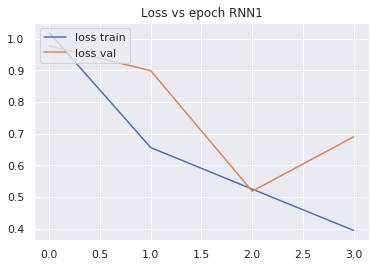

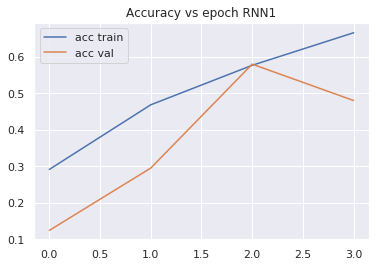


------ Training ------
Accuracy rnn1 : 0.6349670811997074
F1-score None rnn1 : [0.71525289 0.60857664 0.68440298 0.48511577]
F1-score macro rnn1 : 0.6233370678897948

------ Validation ------
Accuracy rnn1 : 0.4804270462633452
F1-score None rnn1 : [0.53521127 0.05882353 0.40650407 0.53992395]
F1-score macro rnn1 : 0.3851157041076681

------ Testing ------
Accuracy rnn1 : 0.42115572967678744
F1-score None rnn1 : [0.25870647 0.17877095 0.32720588 0.53488372]
F1-score macro rnn1 : 0.3248917551663839


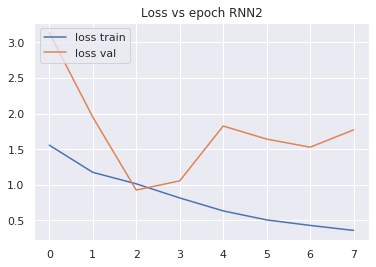


------ Training ------
Accuracy rnn2 : 0.8861558156547183
F1-score None rnn2 : [0.84536418 0.94523684 0.97353322 0.76638728]
F1-score macro rnn2 : 0.8826303803089556

------ Validation ------
Accuracy rnn2 : 0.4875444839857651
F1-score None rnn2 : [0.47252747 0.17241379 0.42553191 0.57454545]
F1-score macro rnn2 : 0.4112546587674981

------ Testing ------
Accuracy rnn2 : 0.49559255631733595
F1-score None rnn2 : [0.15977961 0.23715415 0.48192771 0.64603175]
F1-score macro rnn2 : 0.3812233053494542


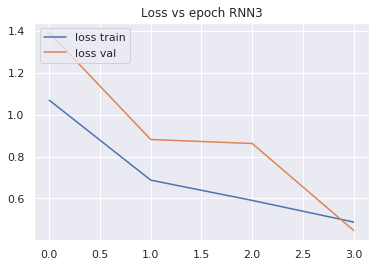


------ Training ------
Accuracy rnn3 : 0.6194220921726408
F1-score None rnn3 : [0.70306007 0.28527795 0.80259002 0.5464716 ]
F1-score macro rnn3 : 0.5843499087765531

------ Validation ------
Accuracy rnn3 : 0.6761565836298933
F1-score None rnn3 : [0.60810811 0.23529412 0.58974359 0.7523511 ]
F1-score macro rnn3 : 0.54637422816936

------ Testing ------
Accuracy rnn3 : 0.6503428011753183
F1-score None rnn3 : [0.25396825 0.08888889 0.50145773 0.77464789]
F1-score macro rnn3 : 0.4047406890321521

Entrenando exec  3 



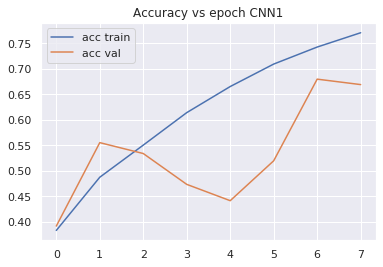


------ Training ------
Accuracy cnn1 : 0.8566203365032918
F1-score None cnn1 : [0.83685158 0.88839376 0.96507937 0.74382885]
F1-score macro cnn1 : 0.858538389782667

------ Validation ------
Accuracy cnn1 : 0.6690391459074733
F1-score None cnn1 : [0.58426966 0.35294118 0.57142857 0.74461538]
F1-score macro cnn1 : 0.5633136988589731

------ Testing ------
Accuracy cnn1 : 0.6170421155729677
F1-score None cnn1 : [0.1829653  0.11627907 0.45121951 0.7579661 ]
F1-score macro cnn1 : 0.3771074958355054


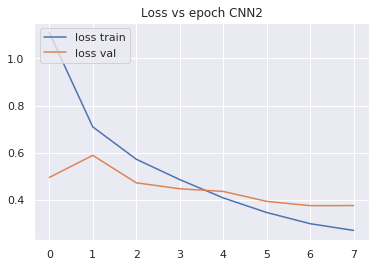

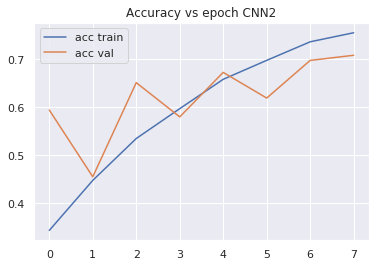


------ Training ------
Accuracy cnn2 : 0.8750914411119239
F1-score None cnn2 : [0.83324079 0.9338179  0.95950156 0.78146611]
F1-score macro cnn2 : 0.8770065916993122

------ Validation ------
Accuracy cnn2 : 0.708185053380783
F1-score None cnn2 : [0.625      0.38095238 0.53061224 0.78735632]
F1-score macro cnn2 : 0.5809802369223551

------ Testing ------
Accuracy cnn2 : 0.692458374142997
F1-score None cnn2 : [0.21463415 0.13186813 0.48044693 0.81174218]
F1-score macro cnn2 : 0.40967284702456386



------ Training ------
Accuracy rnn1 : 0.42309802487198245
F1-score None rnn1 : [0.48018223 0.49160857 0.35665781 0.23975804]
F1-score macro rnn1 : 0.39205166403146297

------ Validation ------
Accuracy rnn1 : 0.3736654804270463
F1-score None rnn1 : [0.45423729 0.19047619 0.4        0.27184466]
F1-score macro rnn1 : 0.3291395347014896

------ Testing ------
Accuracy rnn1 : 0.24289911851126347
F1-score None rnn1 : [0.15112161 0.22033898 0.27480916 0.32346723]
F1-score macro rnn1 : 0.24243424486680645


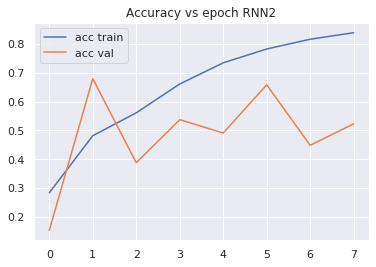


------ Training ------
Accuracy rnn2 : 0.8858814923189466
F1-score None rnn2 : [0.8595011  0.93938307 0.94261201 0.80514378]
F1-score macro rnn2 : 0.8866599894821395

------ Validation ------
Accuracy rnn2 : 0.5231316725978647
F1-score None rnn2 : [0.41481481 0.08695652 0.30769231 0.68965517]
F1-score macro rnn2 : 0.3747797041650115

------ Testing ------
Accuracy rnn2 : 0.6258570029382958
F1-score None rnn2 : [0.16161616 0.16216216 0.4        0.76851234]
F1-score macro rnn2 : 0.37307266633484115


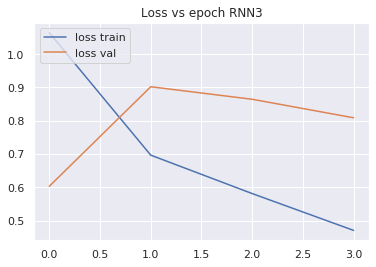

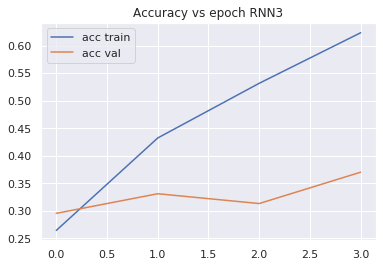


------ Training ------
Accuracy rnn3 : 0.68050475493782
F1-score None rnn3 : [0.70063449 0.70427501 0.81953778 0.38426787]
F1-score macro rnn3 : 0.6521787891139097

------ Validation ------
Accuracy rnn3 : 0.3701067615658363
F1-score None rnn3 : [0.39473684 0.16161616 0.51219512 0.3930131 ]
F1-score macro rnn3 : 0.3653903065273314

------ Testing ------
Accuracy rnn3 : 0.34084231145935356
F1-score None rnn3 : [0.24786325 0.21491228 0.4265928  0.38950555]
F1-score macro rnn3 : 0.3197184690746204

Entrenando exec  4 



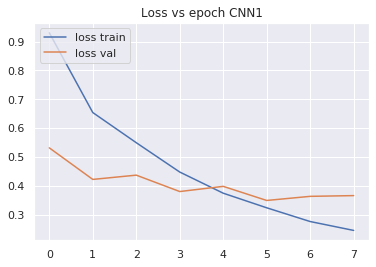

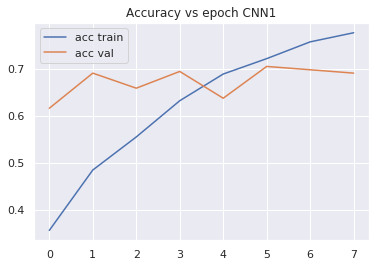


------ Training ------
Accuracy cnn1 : 0.879572055596196
F1-score None cnn1 : [0.85570586 0.91828336 0.96841725 0.77846943]
F1-score macro cnn1 : 0.8802189757498906

------ Validation ------
Accuracy cnn1 : 0.6903914590747331
F1-score None cnn1 : [0.60377358 0.4        0.59259259 0.76047904]
F1-score macro cnn1 : 0.5892113048536052

------ Testing ------
Accuracy cnn1 : 0.6777668952007836
F1-score None cnn1 : [0.18181818 0.10126582 0.59047619 0.79947055]
F1-score macro cnn1 : 0.4182576860960696


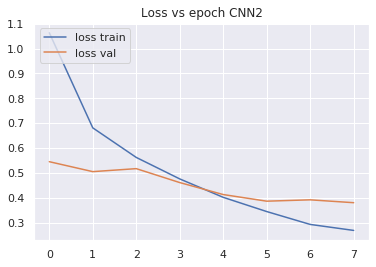


------ Training ------
Accuracy cnn2 : 0.8846927578639356
F1-score None cnn2 : [0.84980602 0.9338507  0.96356575 0.79539007]
F1-score macro cnn2 : 0.8856531359270035

------ Validation ------
Accuracy cnn2 : 0.7046263345195729
F1-score None cnn2 : [0.63380282 0.33333333 0.5        0.78409091]
F1-score macro cnn2 : 0.5628067648314128

------ Testing ------
Accuracy cnn2 : 0.6787463271302644
F1-score None cnn2 : [0.14371257 0.23225806 0.47619048 0.80283505]
F1-score macro cnn2 : 0.4137490417758241



------ Training ------
Accuracy rnn1 : 0.7236649597659107
F1-score None rnn1 : [0.73983005 0.74902079 0.88652361 0.41258381]
F1-score macro rnn1 : 0.6969895623614968

------ Validation ------
Accuracy rnn1 : 0.4234875444839858
F1-score None rnn1 : [0.52229299 0.14       0.51428571 0.45106383]
F1-score macro rnn1 : 0.4069106344258804

------ Testing ------
Accuracy rnn1 : 0.38001958863858964
F1-score None rnn1 : [0.25726141 0.19340659 0.45695364 0.46743295]
F1-score macro rnn1 : 0.343763649192663


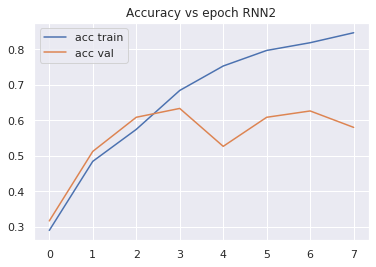


------ Training ------
Accuracy rnn2 : 0.8782918800292612
F1-score None rnn2 : [0.79731149 0.94010695 0.96623471 0.80471604]
F1-score macro rnn2 : 0.8770922991502172

------ Validation ------
Accuracy rnn2 : 0.5800711743772242
F1-score None rnn2 : [0.43103448 0.16129032 0.47272727 0.72948328]
F1-score macro rnn2 : 0.4486338401853276

------ Testing ------
Accuracy rnn2 : 0.653281096963761
F1-score None rnn2 : [0.0862069  0.16410256 0.39408867 0.79319372]
F1-score macro rnn2 : 0.35939796197062857


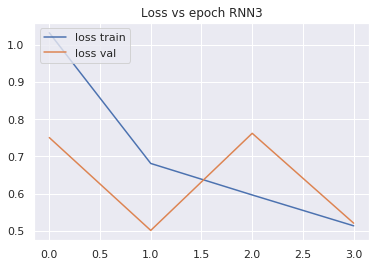

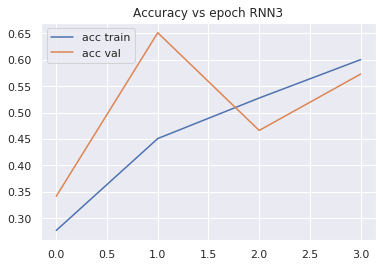


------ Training ------
Accuracy rnn3 : 0.5822970007315289
F1-score None rnn3 : [0.62657092 0.24526545 0.78543307 0.50587634]
F1-score macro rnn3 : 0.5407864433345326

------ Validation ------
Accuracy rnn3 : 0.5729537366548043
F1-score None rnn3 : [0.52513966 0.13333333 0.55421687 0.63157895]
F1-score macro rnn3 : 0.4610672032440258

------ Testing ------
Accuracy rnn3 : 0.5739471106758081
F1-score None rnn3 : [0.22857143 0.13043478 0.5442623  0.70579151]
F1-score macro rnn3 : 0.4022650030133993

Entrenando exec  5 



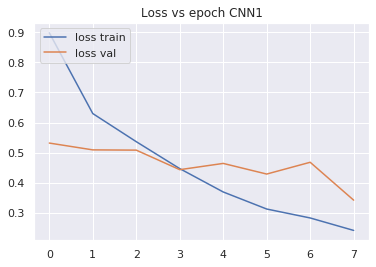

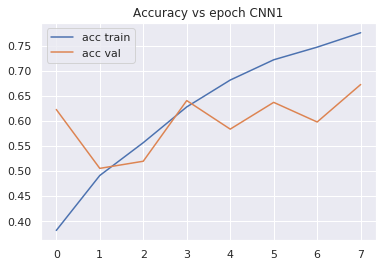


------ Training ------
Accuracy cnn1 : 0.8790234089246525
F1-score None cnn1 : [0.84730234 0.93471698 0.96979622 0.761868  ]
F1-score macro cnn1 : 0.8784208856392486

------ Validation ------
Accuracy cnn1 : 0.6725978647686833
F1-score None cnn1 : [0.57831325 0.43478261 0.66666667 0.73913043]
F1-score macro cnn1 : 0.604723240789244

------ Testing ------
Accuracy cnn1 : 0.6150832517140059
F1-score None cnn1 : [0.21754386 0.20689655 0.49717514 0.74982578]
F1-score macro cnn1 : 0.417860334147081


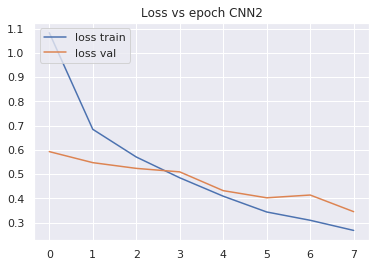

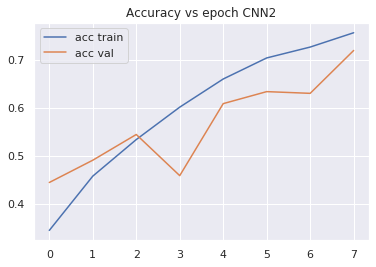


------ Training ------
Accuracy cnn2 : 0.8431784930504755
F1-score None cnn2 : [0.83768323 0.84161752 0.96611418 0.74      ]
F1-score macro cnn2 : 0.8463537339201983

------ Validation ------
Accuracy cnn2 : 0.7188612099644128
F1-score None cnn2 : [0.6122449  0.28571429 0.6122449  0.79545455]
F1-score macro cnn2 : 0.5764146567717996

------ Testing ------
Accuracy cnn2 : 0.6993143976493633
F1-score None cnn2 : [0.25       0.08       0.51648352 0.81486227]
F1-score macro cnn2 : 0.41533644606514564



------ Training ------
Accuracy rnn1 : 0.6721836137527433
F1-score None rnn1 : [0.70719827 0.65879923 0.8331547  0.41801619]
F1-score macro rnn1 : 0.6542920983623837

------ Validation ------
Accuracy rnn1 : 0.42704626334519574
F1-score None rnn1 : [0.5398773  0.16326531 0.55072464 0.42241379]
F1-score macro rnn1 : 0.4190702593801384

------ Testing ------
Accuracy rnn1 : 0.3643486777668952
F1-score None rnn1 : [0.21774194 0.19844358 0.552      0.4368932 ]
F1-score macro rnn1 : 0.3512696797834758


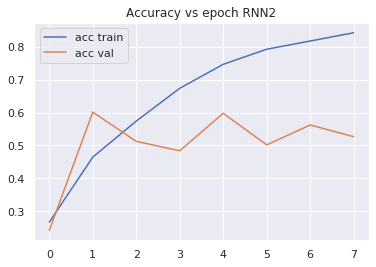


------ Training ------
Accuracy rnn2 : 0.8814008778346745
F1-score None rnn2 : [0.86607979 0.92956764 0.93512852 0.78259157]
F1-score macro rnn2 : 0.8783418809090843

------ Validation ------
Accuracy rnn2 : 0.5266903914590747
F1-score None rnn2 : [0.41481481 0.21621622 0.50793651 0.66206897]
F1-score macro rnn2 : 0.45025912612119506

------ Testing ------
Accuracy rnn2 : 0.5582761998041136
F1-score None rnn2 : [0.20540541 0.16143498 0.38538206 0.71267817]
F1-score macro rnn2 : 0.3662251530817327


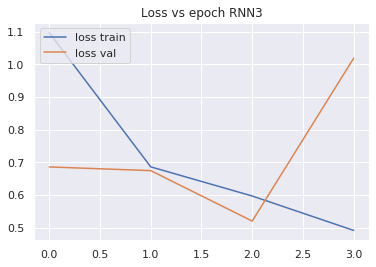


------ Training ------
Accuracy rnn3 : 0.5940014630577908
F1-score None rnn3 : [0.6360671  0.66015625 0.69286995 0.16007593]
F1-score macro rnn3 : 0.5372923064742452

------ Validation ------
Accuracy rnn3 : 0.27402135231316727
F1-score None rnn3 : [0.45614035 0.13207547 0.3537415  0.18461538]
F1-score macro rnn3 : 0.28164317594733257

------ Testing ------
Accuracy rnn3 : 0.20861900097943192
F1-score None rnn3 : [0.23931624 0.15578947 0.29881154 0.17189315]
F1-score macro rnn3 : 0.2164526013737161


In [20]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [21]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5)

0.15 Clase Ponderado - F1-score promedio para cnn1 : [0.20410795 0.11088056 0.51924958 0.77943512]
0.15 Clase Ponderado - F1-score promedio para cnn2 : [0.19452431 0.1418962  0.4977806  0.80820696]
0.15 Clase Ponderado - F1-score promedio para rnn1 : [0.22467271 0.19303073 0.37450143 0.44825237]
0.15 Clase Ponderado - F1-score promedio para rnn2 : [0.12260162 0.17504596 0.41837834 0.7491822 ]
0.15 Clase Ponderado - F1-score promedio para rnn3 : [0.24051918 0.168638   0.44820078 0.54234198]

0.15 Clase Ponderado - F1-score macro promedio para cnn1 : 0.40341830213457336 desvest:  0.015275084027898601
0.15 Clase Ponderado - F1-score macro promedio para cnn2 : 0.4106020189257057 desvest:  0.010290109455548003
0.15 Clase Ponderado - F1-score macro promedio para rnn1 : 0.31011430830179976 desvest:  0.04026092017604733
0.15 Clase Ponderado - F1-score macro promedio para rnn2 : 0.36630203049219007 desvest:  0.010320566939550871
0.15 Clase Ponderado - F1-score macro promedio para rnn3 : 0.34992

#### Sujeto a Vocabulario BERT

In [22]:
macro_augmented = np.load('../Datasets/CSV_Stance/balance_bert_noPon.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



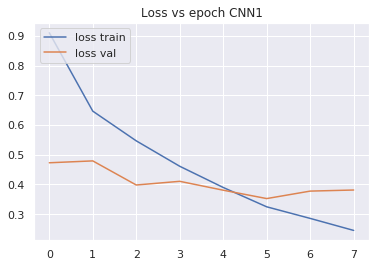

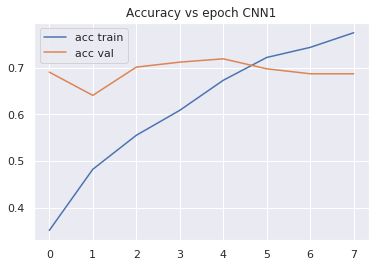


------ Training ------
Accuracy cnn1 : 0.8884418434528164
F1-score None cnn1 : [0.84727996 0.94218989 0.97171864 0.79692802]
F1-score macro cnn1 : 0.8895291272452062

------ Validation ------
Accuracy cnn1 : 0.6868327402135231
F1-score None cnn1 : [0.56756757 0.13333333 0.61818182 0.77325581]
F1-score macro cnn1 : 0.5230846332590519

------ Testing ------
Accuracy cnn1 : 0.6993143976493633
F1-score None cnn1 : [0.20183486 0.17204301 0.58       0.81776617]
F1-score macro cnn1 : 0.44291100976066167


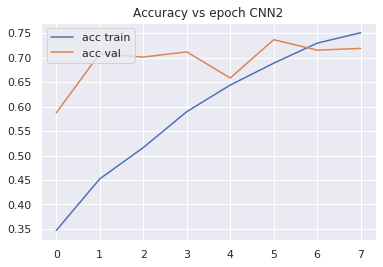


------ Training ------
Accuracy cnn2 : 0.8666788588149232
F1-score None cnn2 : [0.8254858  0.90318725 0.9609642  0.78471638]
F1-score macro cnn2 : 0.8685884076514728

------ Validation ------
Accuracy cnn2 : 0.7188612099644128
F1-score None cnn2 : [0.5942029  0.26666667 0.66666667 0.7965616 ]
F1-score macro cnn2 : 0.5810244591171463

------ Testing ------
Accuracy cnn2 : 0.7169441723800196
F1-score None cnn2 : [0.1547619  0.075      0.59459459 0.82697201]
F1-score macro cnn2 : 0.4128321273836541


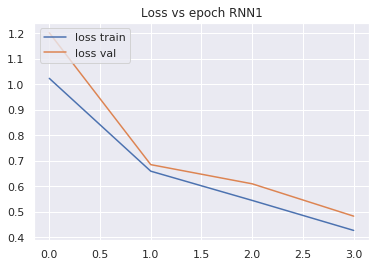

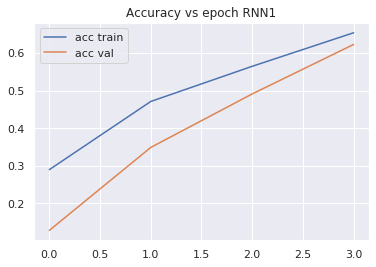


------ Training ------
Accuracy rnn1 : 0.6776700804681784
F1-score None rnn1 : [0.6589317  0.60098522 0.82240949 0.60003015]
F1-score macro rnn1 : 0.6705891402144352

------ Validation ------
Accuracy rnn1 : 0.6227758007117438
F1-score None rnn1 : [0.53968254 0.27777778 0.5        0.725     ]
F1-score macro rnn1 : 0.5106150793650793

------ Testing ------
Accuracy rnn1 : 0.6523016650342801
F1-score None rnn1 : [0.14414414 0.21192053 0.46884273 0.78031878]
F1-score macro rnn1 : 0.40130654605864385


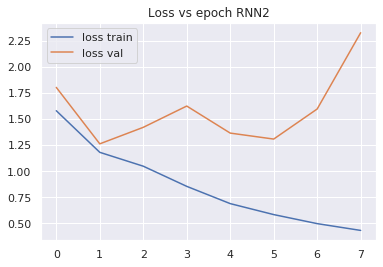

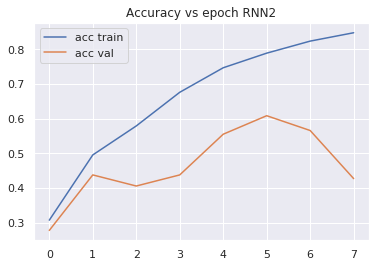


------ Training ------
Accuracy rnn2 : 0.8189465983906364
F1-score None rnn2 : [0.849295   0.8020199  0.95478871 0.63395163]
F1-score macro rnn2 : 0.810013810283196

------ Validation ------
Accuracy rnn2 : 0.42704626334519574
F1-score None rnn2 : [0.4966443  0.13207547 0.4        0.51587302]
F1-score macro rnn2 : 0.3861481957182856

------ Testing ------
Accuracy rnn2 : 0.40254652301665034
F1-score None rnn2 : [0.17674419 0.16803279 0.44239631 0.54010695]
F1-score macro rnn2 : 0.33182005954186766


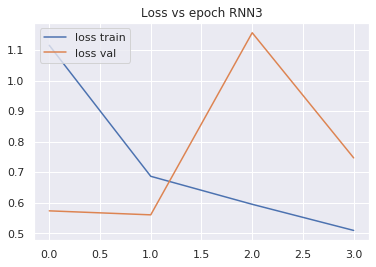

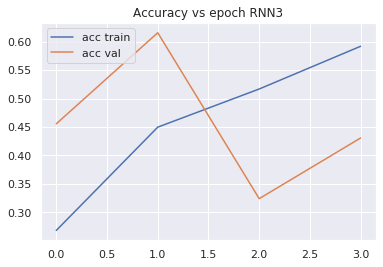


------ Training ------
Accuracy rnn3 : 0.6287490855888808
F1-score None rnn3 : [0.66345285 0.58893752 0.77344877 0.39385545]
F1-score macro rnn3 : 0.6049236493974472

------ Validation ------
Accuracy rnn3 : 0.4306049822064057
F1-score None rnn3 : [0.48275862 0.18181818 0.52380952 0.3982684 ]
F1-score macro rnn3 : 0.39666368114643974

------ Testing ------
Accuracy rnn3 : 0.3731635651322233
F1-score None rnn3 : [0.20565553 0.20074349 0.43874644 0.4588577 ]
F1-score macro rnn3 : 0.32600078904837404

Entrenando exec  2 




------ Training ------
Accuracy cnn1 : 0.8783833211411851
F1-score None cnn1 : [0.8482746  0.92470634 0.96065635 0.78986128]
F1-score macro cnn1 : 0.8808746412526883

------ Validation ------
Accuracy cnn1 : 0.7188612099644128
F1-score None cnn1 : [0.62937063 0.23529412 0.58333333 0.79661017]
F1-score macro cnn1 : 0.5611520624606368

------ Testing ------
Accuracy cnn1 : 0.7140058765915769
F1-score None cnn1 : [0.21276596 0.17204301 0.52222222 0.82732448]
F1-score macro cnn1 : 0.4335889171500217


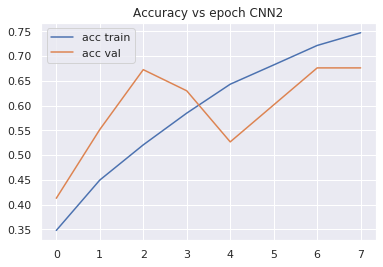


------ Training ------
Accuracy cnn2 : 0.8696049743964887
F1-score None cnn2 : [0.83654858 0.91239605 0.96428571 0.77325271]
F1-score macro cnn2 : 0.8716207651821515

------ Validation ------
Accuracy cnn2 : 0.6761565836298933
F1-score None cnn2 : [0.59210526 0.28571429 0.54545455 0.75362319]
F1-score macro cnn2 : 0.5442243206831308

------ Testing ------
Accuracy cnn2 : 0.6699314397649363
F1-score None cnn2 : [0.17840376 0.18181818 0.51461988 0.79375407]
F1-score macro cnn2 : 0.41714897177267674


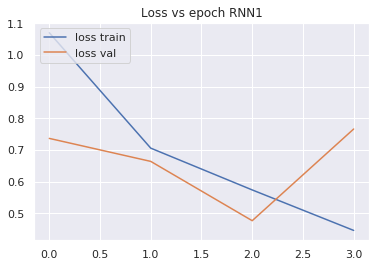

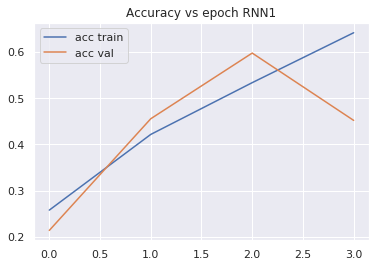


------ Training ------
Accuracy rnn1 : 0.7035479151426481
F1-score None rnn1 : [0.67900969 0.76830526 0.78698752 0.52726106]
F1-score macro rnn1 : 0.6903908836106256

------ Validation ------
Accuracy rnn1 : 0.45195729537366547
F1-score None rnn1 : [0.45378151 0.15625    0.37288136 0.55938697]
F1-score macro rnn1 : 0.38557496042933054

------ Testing ------
Accuracy rnn1 : 0.44662095984329087
F1-score None rnn1 : [0.27710843 0.22929936 0.37327189 0.56028369]
F1-score macro rnn1 : 0.3599908435341122


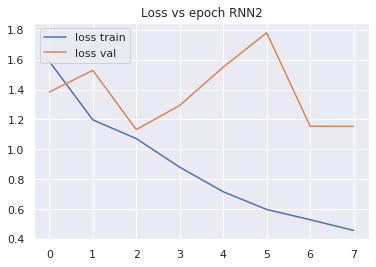

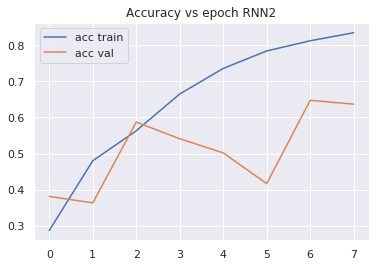


------ Training ------
Accuracy rnn2 : 0.8474762253108998
F1-score None rnn2 : [0.80317262 0.87620192 0.96353591 0.76317765]
F1-score macro rnn2 : 0.8515220260754932

------ Validation ------
Accuracy rnn2 : 0.6370106761565836
F1-score None rnn2 : [0.46616541 0.19354839 0.56521739 0.75      ]
F1-score macro rnn2 : 0.49373279798373915

------ Testing ------
Accuracy rnn2 : 0.7140058765915769
F1-score None rnn2 : [0.10526316 0.16949153 0.4278607  0.83281541]
F1-score macro rnn2 : 0.3838576982840163


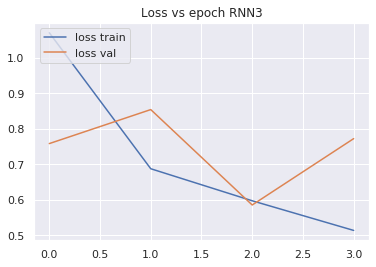

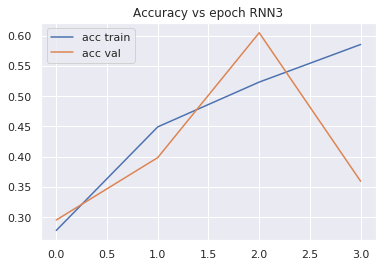


------ Training ------
Accuracy rnn3 : 0.5966532553035845
F1-score None rnn3 : [0.69967664 0.57968648 0.70536311 0.22991273]
F1-score macro rnn3 : 0.5536597398649544

------ Validation ------
Accuracy rnn3 : 0.3594306049822064
F1-score None rnn3 : [0.62318841 0.11764706 0.39416058 0.25742574]
F1-score macro rnn3 : 0.34810544778412356

------ Testing ------
Accuracy rnn3 : 0.25367286973555336
F1-score None rnn3 : [0.26573427 0.17155756 0.34163701 0.23713647]
F1-score macro rnn3 : 0.25401632595288914

Entrenando exec  3 



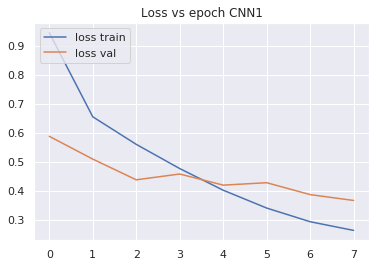

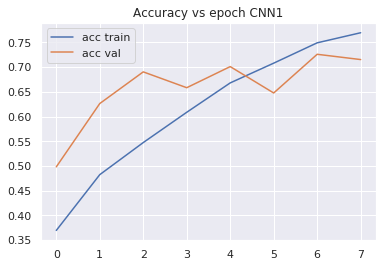


------ Training ------
Accuracy cnn1 : 0.8603694220921726
F1-score None cnn1 : [0.76631228 0.93899906 0.96544276 0.77217224]
F1-score macro cnn1 : 0.8607315838257568

------ Validation ------
Accuracy cnn1 : 0.7153024911032029
F1-score None cnn1 : [0.64179104 0.26666667 0.65517241 0.79411765]
F1-score macro cnn1 : 0.5894369430736782

------ Testing ------
Accuracy cnn1 : 0.7375122428991185
F1-score None cnn1 : [0.08163265 0.22222222 0.57777778 0.84118016]
F1-score macro cnn1 : 0.43070320406882157



------ Training ------
Accuracy cnn2 : 0.8730797366495977
F1-score None cnn2 : [0.826128   0.91695238 0.96848663 0.78745526]
F1-score macro cnn2 : 0.8747555653232951

------ Validation ------
Accuracy cnn2 : 0.6476868327402135
F1-score None cnn2 : [0.46031746 0.34482759 0.64150943 0.74011299]
F1-score macro cnn2 : 0.5466918687092259

------ Testing ------
Accuracy cnn2 : 0.6963761018609207
F1-score None cnn2 : [0.11842105 0.27096774 0.54444444 0.81286174]
F1-score macro cnn2 : 0.43667374383647806


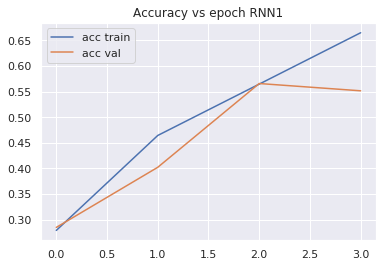


------ Training ------
Accuracy rnn1 : 0.6362472567666423
F1-score None rnn1 : [0.67162997 0.53079396 0.8022934  0.53762775]
F1-score macro rnn1 : 0.6355862699773357

------ Validation ------
Accuracy rnn1 : 0.5516014234875445
F1-score None rnn1 : [0.54644809 0.06666667 0.43137255 0.62416107]
F1-score macro rnn1 : 0.4171620942358679

------ Testing ------
Accuracy rnn1 : 0.5798237022526934
F1-score None rnn1 : [0.21453287 0.20915033 0.41836735 0.71794872]
F1-score macro rnn1 : 0.38999981591429933


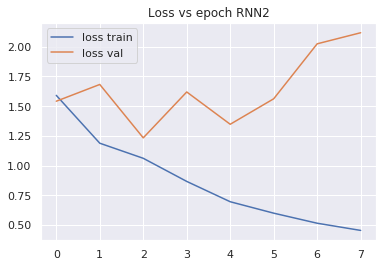

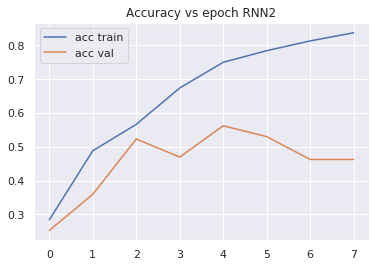


------ Training ------
Accuracy rnn2 : 0.8013899049012436
F1-score None rnn2 : [0.84546137 0.77448157 0.92208286 0.64374712]
F1-score macro rnn2 : 0.796443226554689

------ Validation ------
Accuracy rnn2 : 0.4626334519572954
F1-score None rnn2 : [0.52702703 0.16071429 0.5        0.5511811 ]
F1-score macro rnn2 : 0.43473060377587935

------ Testing ------
Accuracy rnn2 : 0.42703232125367285
F1-score None rnn2 : [0.21212121 0.17849899 0.42574257 0.57093124]
F1-score macro rnn2 : 0.34682350418508556


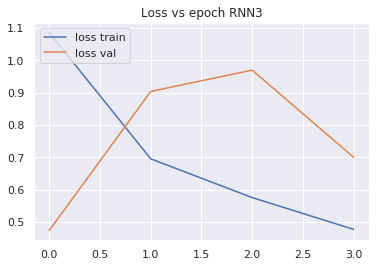

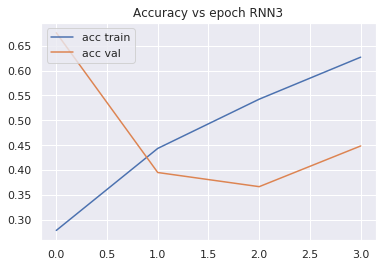


------ Training ------
Accuracy rnn3 : 0.6721836137527433
F1-score None rnn3 : [0.66871921 0.67260083 0.82017544 0.48870447]
F1-score macro rnn3 : 0.662549989254616

------ Validation ------
Accuracy rnn3 : 0.4483985765124555
F1-score None rnn3 : [0.46043165 0.1682243  0.59701493 0.52208835]
F1-score macro rnn3 : 0.4369398081321171

------ Testing ------
Accuracy rnn3 : 0.4201762977473066
F1-score None rnn3 : [0.13186813 0.16803279 0.60606061 0.53429603]
F1-score macro rnn3 : 0.3600643884237126

Entrenando exec  4 



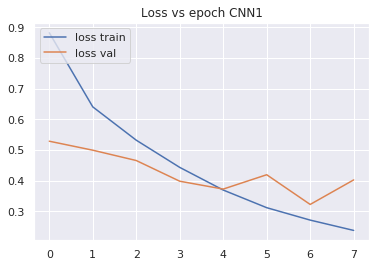

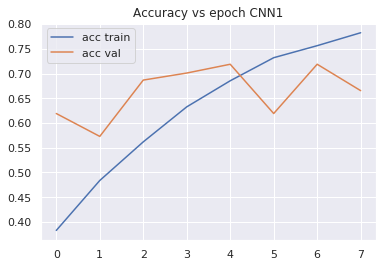


------ Training ------
Accuracy cnn1 : 0.8655815654718362
F1-score None cnn1 : [0.83316783 0.90352282 0.96718289 0.76487985]
F1-score macro cnn1 : 0.8671883466147976

------ Validation ------
Accuracy cnn1 : 0.6654804270462633
F1-score None cnn1 : [0.57831325 0.28571429 0.56521739 0.73809524]
F1-score macro cnn1 : 0.54183504203148

------ Testing ------
Accuracy cnn1 : 0.6493633692458374
F1-score None cnn1 : [0.16788321 0.17073171 0.45882353 0.78364116]
F1-score macro cnn1 : 0.3952699023393845


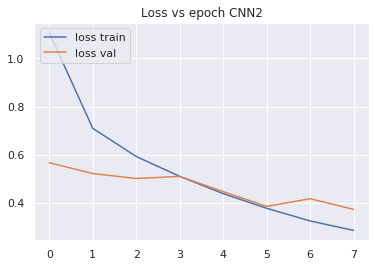

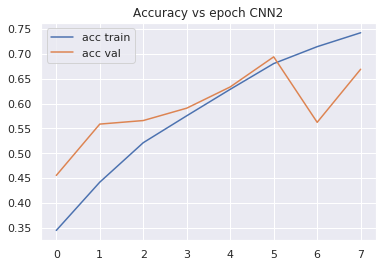


------ Training ------
Accuracy cnn2 : 0.8572604242867593
F1-score None cnn2 : [0.82604238 0.90181239 0.96617297 0.74213382]
F1-score macro cnn2 : 0.8590403892864337

------ Validation ------
Accuracy cnn2 : 0.6690391459074733
F1-score None cnn2 : [0.60493827 0.35294118 0.46808511 0.74404762]
F1-score macro cnn2 : 0.5425030433765311

------ Testing ------
Accuracy cnn2 : 0.6660137120470128
F1-score None cnn2 : [0.24719101 0.17777778 0.5106383  0.78957916]
F1-score macro cnn2 : 0.4312965613006766


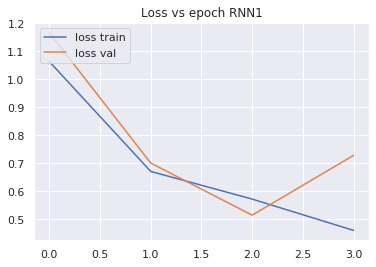

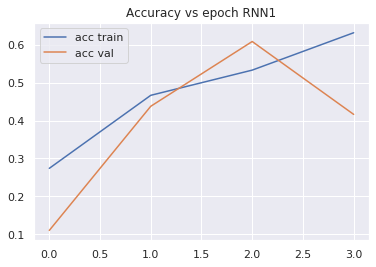


------ Training ------
Accuracy rnn1 : 0.6046086320409656
F1-score None rnn1 : [0.71377291 0.51766438 0.65459375 0.4535545 ]
F1-score macro rnn1 : 0.5848963832626873

------ Validation ------
Accuracy rnn1 : 0.41637010676156583
F1-score None rnn1 : [0.52348993 0.09756098 0.34328358 0.44537815]
F1-score macro rnn1 : 0.35242816046142966

------ Testing ------
Accuracy rnn1 : 0.3780607247796278
F1-score None rnn1 : [0.2464455  0.18404908 0.31647635 0.47014218]
F1-score macro rnn1 : 0.3042782758299626


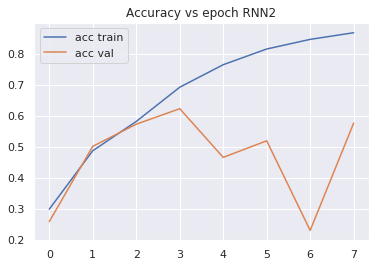


------ Training ------
Accuracy rnn2 : 0.7988295537673739
F1-score None rnn2 : [0.85810012 0.90807327 0.70979841 0.71368294]
F1-score macro rnn2 : 0.7974136839488626

------ Validation ------
Accuracy rnn2 : 0.5765124555160143
F1-score None rnn2 : [0.53333333 0.15625    0.32432432 0.70552147]
F1-score macro rnn2 : 0.4298572825125739

------ Testing ------
Accuracy rnn2 : 0.6317335945151812
F1-score None rnn2 : [0.07142857 0.26388889 0.176      0.7804878 ]
F1-score macro rnn2 : 0.3229513162988773


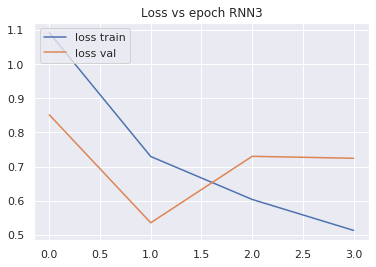

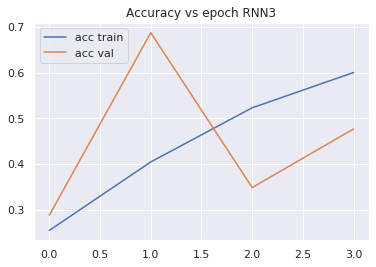


------ Training ------
Accuracy rnn3 : 0.6101865398683248
F1-score None rnn3 : [0.67009206 0.59767584 0.67257421 0.50842199]
F1-score macro rnn3 : 0.6121910244318277

------ Validation ------
Accuracy rnn3 : 0.47686832740213525
F1-score None rnn3 : [0.55555556 0.14754098 0.59259259 0.56923077]
F1-score macro rnn3 : 0.4662299752463687

------ Testing ------
Accuracy rnn3 : 0.4534769833496572
F1-score None rnn3 : [0.26277372 0.18014706 0.56363636 0.58545136]
F1-score macro rnn3 : 0.3980021258862809

Entrenando exec  5 



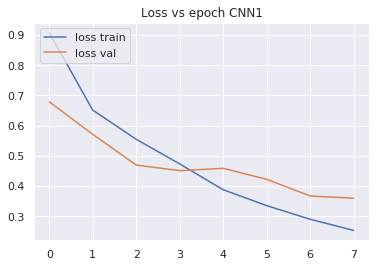


------ Training ------
Accuracy cnn1 : 0.8838697878566203
F1-score None cnn1 : [0.81530984 0.95139147 0.96572983 0.80477691]
F1-score macro cnn1 : 0.8843020117637438

------ Validation ------
Accuracy cnn1 : 0.7366548042704626
F1-score None cnn1 : [0.62222222 0.34782609 0.7037037  0.81142857]
F1-score macro cnn1 : 0.6212951460777548

------ Testing ------
Accuracy cnn1 : 0.7394711067580804
F1-score None cnn1 : [0.13793103 0.21138211 0.62325581 0.84005038]
F1-score macro cnn1 : 0.4531548350227846


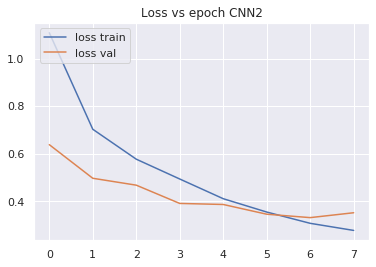

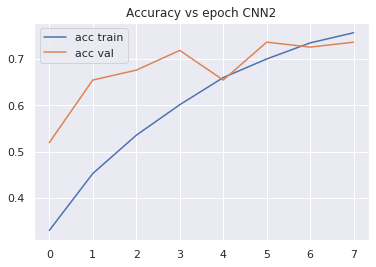


------ Training ------
Accuracy cnn2 : 0.8613752743233358
F1-score None cnn2 : [0.80892823 0.91622523 0.95078497 0.77441191]
F1-score macro cnn2 : 0.8625875858188226

------ Validation ------
Accuracy cnn2 : 0.7366548042704626
F1-score None cnn2 : [0.61870504 0.375      0.67647059 0.81415929]
F1-score macro cnn2 : 0.6210837290604788

------ Testing ------
Accuracy cnn2 : 0.7140058765915769
F1-score None cnn2 : [0.09937888 0.08       0.61417323 0.82474227]
F1-score macro cnn2 : 0.4045735945938178


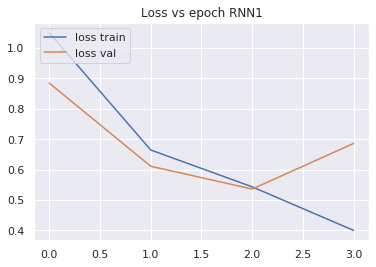

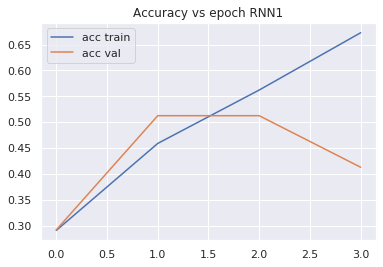


------ Training ------
Accuracy rnn1 : 0.721104608632041
F1-score None rnn1 : [0.71794872 0.72352177 0.89800324 0.49760547]
F1-score macro rnn1 : 0.7092697991316711

------ Validation ------
Accuracy rnn1 : 0.4128113879003559
F1-score None rnn1 : [0.44736842 0.1        0.54545455 0.48360656]
F1-score macro rnn1 : 0.3941073809710565

------ Testing ------
Accuracy rnn1 : 0.4299706170421156
F1-score None rnn1 : [0.23938224 0.18       0.53617021 0.53832753]
F1-score macro rnn1 : 0.37346999457015023


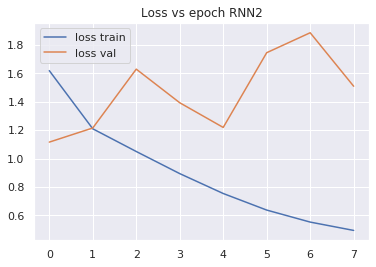

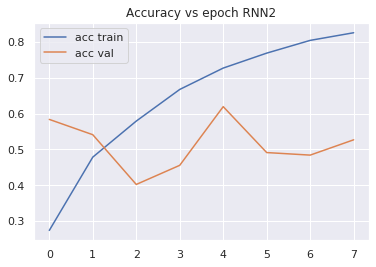


------ Training ------
Accuracy rnn2 : 0.8461960497439649
F1-score None rnn2 : [0.82760966 0.88627049 0.93557942 0.71766695]
F1-score macro rnn2 : 0.8417816279625806

------ Validation ------
Accuracy rnn2 : 0.5266903914590747
F1-score None rnn2 : [0.51162791 0.21875    0.51851852 0.61029412]
F1-score macro rnn2 : 0.4647976357855804

------ Testing ------
Accuracy rnn2 : 0.5220372184133203
F1-score None rnn2 : [0.18181818 0.22727273 0.51851852 0.66826156]
F1-score macro rnn2 : 0.3989677476519582


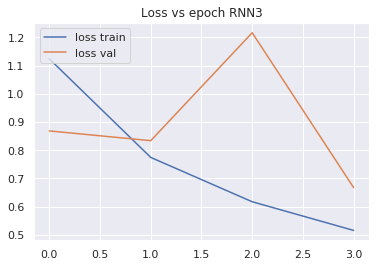

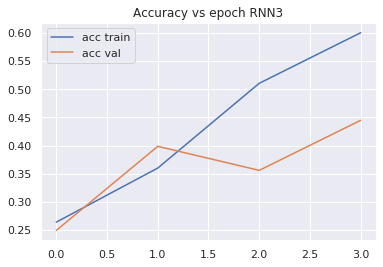


------ Training ------
Accuracy rnn3 : 0.6510607168983175
F1-score None rnn3 : [0.67397089 0.66122874 0.7946814  0.38727735]
F1-score macro rnn3 : 0.6292895958372526

------ Validation ------
Accuracy rnn3 : 0.44483985765124556
F1-score None rnn3 : [0.52849741 0.1875     0.5974026  0.39473684]
F1-score macro rnn3 : 0.42703421220857135

------ Testing ------
Accuracy rnn3 : 0.3731635651322233
F1-score None rnn3 : [0.17971014 0.19373219 0.50641026 0.45841393]
F1-score macro rnn3 : 0.33456663039225476


In [23]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [24]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 BERT - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 BERT - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 BERT - Accuracy promedio para",key,":" ,temp/5)

0.15 BERT - F1-score promedio para cnn1 : [0.16040954 0.18968441 0.55241587 0.82199247]
0.15 BERT - F1-score promedio para cnn2 : [0.15963132 0.15711274 0.55569409 0.80958185]
0.15 BERT - F1-score promedio para rnn1 : [0.22432264 0.20288386 0.4226257  0.61340418]
0.15 BERT - F1-score promedio para rnn2 : [0.14947506 0.20143698 0.39810362 0.6785206 ]
0.15 BERT - F1-score promedio para rnn3 : [0.20914836 0.18284262 0.49129814 0.4548311 ]

0.15 BERT - F1-score macro promedio para cnn1 : 0.4311255736683348 desvest:  0.01957580385754845
0.15 BERT - F1-score macro promedio para cnn2 : 0.4205049997774607 desvest:  0.011847629724306044
0.15 BERT - F1-score macro promedio para rnn1 : 0.3658090951814336 desvest:  0.03383442965410947
0.15 BERT - F1-score macro promedio para rnn2 : 0.356884065192361 desvest:  0.02959548589234764
0.15 BERT - F1-score macro promedio para rnn3 : 0.3345300519407023 desvest:  0.047404464444798476

0.15 BERT - Accuracy promedio para cnn1 : 0.7079333986287955
0.15 BERT -

In [25]:
macro_augmented = np.load('../Datasets/CSV_Stance/balance_bert_Pon.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



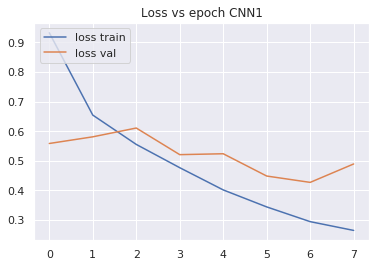


------ Training ------
Accuracy cnn1 : 0.8664045354791514
F1-score None cnn1 : [0.8376398  0.91739895 0.94359756 0.77139875]
F1-score macro cnn1 : 0.8675087633361361

------ Validation ------
Accuracy cnn1 : 0.6441281138790036
F1-score None cnn1 : [0.58914729 0.21052632 0.57777778 0.74924471]
F1-score macro cnn1 : 0.5316740233449733

------ Testing ------
Accuracy cnn1 : 0.6581782566111655
F1-score None cnn1 : [0.14705882 0.22907489 0.47619048 0.78888154]
F1-score macro cnn1 : 0.4103014312486862


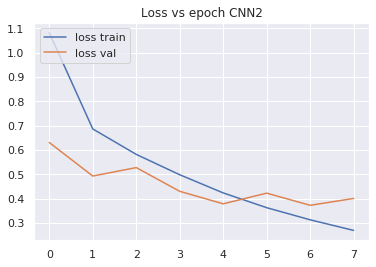

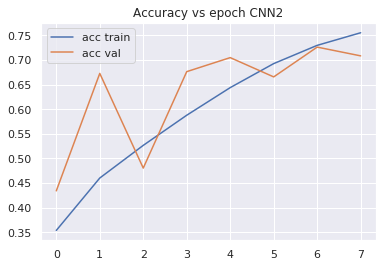


------ Training ------
Accuracy cnn2 : 0.8735369422092173
F1-score None cnn2 : [0.85003658 0.92865362 0.94220201 0.78538813]
F1-score macro cnn2 : 0.8765700844679704

------ Validation ------
Accuracy cnn2 : 0.708185053380783
F1-score None cnn2 : [0.59722222 0.45454545 0.54545455 0.78977273]
F1-score macro cnn2 : 0.5967487373737375

------ Testing ------
Accuracy cnn2 : 0.7042115572967679
F1-score None cnn2 : [0.18888889 0.06060606 0.47204969 0.82521848]
F1-score macro cnn2 : 0.38669077895995335


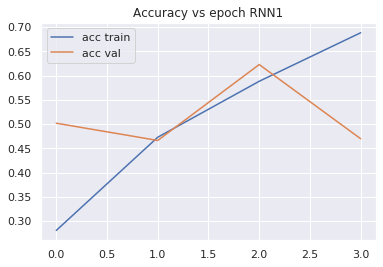


------ Training ------
Accuracy rnn1 : 0.7379297732260425
F1-score None rnn1 : [0.72648221 0.76135148 0.88422114 0.51435185]
F1-score macro rnn1 : 0.721601669976123

------ Validation ------
Accuracy rnn1 : 0.4697508896797153
F1-score None rnn1 : [0.54014599 0.17021277 0.48717949 0.53754941]
F1-score macro rnn1 : 0.4337719114132546

------ Testing ------
Accuracy rnn1 : 0.44564152791381
F1-score None rnn1 : [0.26086957 0.22779043 0.49673203 0.54806828]
F1-score macro rnn1 : 0.3833650770200862


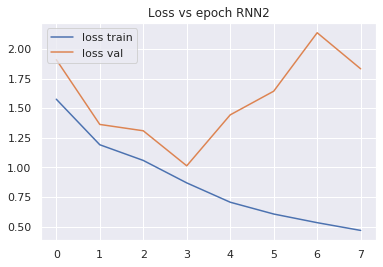


------ Training ------
Accuracy rnn2 : 0.8491221653255303
F1-score None rnn2 : [0.82675134 0.84797458 0.94492861 0.77201166]
F1-score macro rnn2 : 0.84791654888102

------ Validation ------
Accuracy rnn2 : 0.4804270462633452
F1-score None rnn2 : [0.42735043 0.11764706 0.54237288 0.61971831]
F1-score macro rnn2 : 0.42677216934726103

------ Testing ------
Accuracy rnn2 : 0.5631733594515181
F1-score None rnn2 : [0.13253012 0.22478386 0.51020408 0.71267817]
F1-score macro rnn2 : 0.39504905833210907


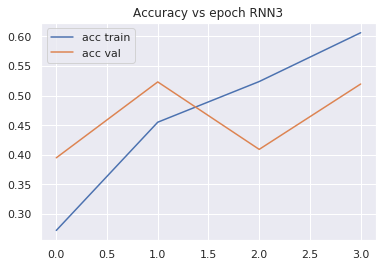


------ Training ------
Accuracy rnn3 : 0.674835405998537
F1-score None rnn3 : [0.68847352 0.65742759 0.80159031 0.55007949]
F1-score macro rnn3 : 0.6743927277143636

------ Validation ------
Accuracy rnn3 : 0.5195729537366548
F1-score None rnn3 : [0.5915493  0.11764706 0.53968254 0.60294118]
F1-score macro rnn3 : 0.4629550176878263

------ Testing ------
Accuracy rnn3 : 0.5034280117531832
F1-score None rnn3 : [0.23602484 0.22018349 0.55319149 0.63140496]
F1-score macro rnn3 : 0.41020119474960426

Entrenando exec  2 



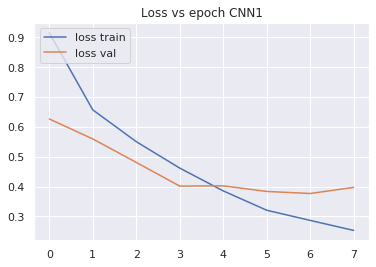

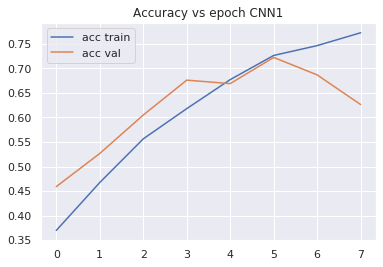


------ Training ------
Accuracy cnn1 : 0.8621982443306511
F1-score None cnn1 : [0.82072101 0.9292968  0.96252252 0.73043478]
F1-score macro cnn1 : 0.8607437796501289

------ Validation ------
Accuracy cnn1 : 0.6263345195729537
F1-score None cnn1 : [0.55737705 0.19047619 0.64285714 0.69536424]
F1-score macro cnn1 : 0.5215186552310642

------ Testing ------
Accuracy cnn1 : 0.5954946131243879
F1-score None cnn1 : [0.22096317 0.1372549  0.59728507 0.72620791]
F1-score macro cnn1 : 0.42042776223359346


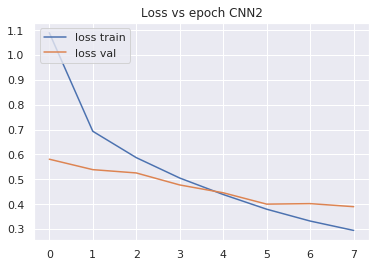


------ Training ------
Accuracy cnn2 : 0.8480248719824433
F1-score None cnn2 : [0.80246513 0.91896054 0.95829539 0.70996016]
F1-score macro cnn2 : 0.8474203055420702

------ Validation ------
Accuracy cnn2 : 0.6654804270462633
F1-score None cnn2 : [0.57471264 0.36363636 0.65454545 0.73954984]
F1-score macro cnn2 : 0.5831110752720687

------ Testing ------
Accuracy cnn2 : 0.5808031341821743
F1-score None cnn2 : [0.21082621 0.1512605  0.54368932 0.71888726]
F1-score macro cnn2 : 0.406165824373826



------ Training ------
Accuracy rnn1 : 0.365764447695684
F1-score None rnn1 : [0.47467672 0.2299937  0.4470973  0.01451379]
F1-score macro rnn1 : 0.2915703781891216

------ Validation ------
Accuracy rnn1 : 0.18861209964412812
F1-score None rnn1 : [0.43809524 0.26666667 0.20817844 0.        ]
F1-score macro rnn1 : 0.22823508585590369

------ Testing ------
Accuracy rnn1 : 0.10969637610186092
F1-score None rnn1 : [0.04545455 0.02325581 0.19354839 0.01021711]
F1-score macro rnn1 : 0.0681189650425494



------ Training ------
Accuracy rnn2 : 0.8782918800292612
F1-score None rnn2 : [0.84415838 0.91477772 0.94266793 0.81365921]
F1-score macro rnn2 : 0.8788158093894973

------ Validation ------
Accuracy rnn2 : 0.5551601423487544
F1-score None rnn2 : [0.4962406  0.14492754 0.41666667 0.69230769]
F1-score macro rnn2 : 0.4375356241775006

------ Testing ------
Accuracy rnn2 : 0.6464250734573947
F1-score None rnn2 : [0.0969697  0.22680412 0.36363636 0.79051383]
F1-score macro rnn2 : 0.3694810045773739


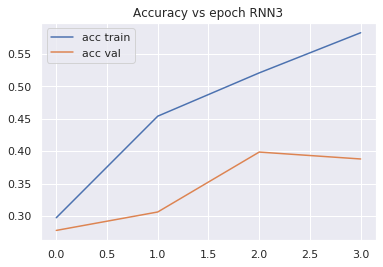


------ Training ------
Accuracy rnn3 : 0.5512984637893197
F1-score None rnn3 : [0.66055046 0.48137536 0.6293021  0.3231888 ]
F1-score macro rnn3 : 0.5236041790634994

------ Validation ------
Accuracy rnn3 : 0.3879003558718861
F1-score None rnn3 : [0.61870504 0.1754386  0.35294118 0.31924883]
F1-score macro rnn3 : 0.36658340880602974

------ Testing ------
Accuracy rnn3 : 0.31243878550440746
F1-score None rnn3 : [0.25974026 0.16393443 0.31921824 0.36326109]
F1-score macro rnn3 : 0.27653850523084045

Entrenando exec  3 



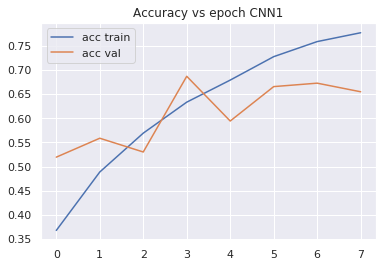


------ Training ------
Accuracy cnn1 : 0.8857900512070227
F1-score None cnn1 : [0.85244767 0.94587434 0.96020539 0.78670153]
F1-score macro cnn1 : 0.8863072335321753

------ Validation ------
Accuracy cnn1 : 0.6548042704626335
F1-score None cnn1 : [0.5125     0.35294118 0.57142857 0.75      ]
F1-score macro cnn1 : 0.5467174369747899

------ Testing ------
Accuracy cnn1 : 0.67384916748286
F1-score None cnn1 : [0.18333333 0.16       0.55248619 0.79947403]
F1-score macro cnn1 : 0.4238233878554746


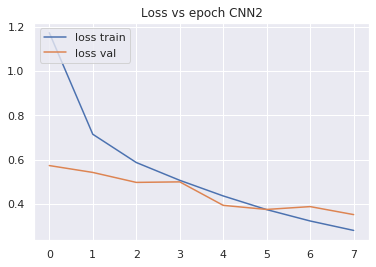

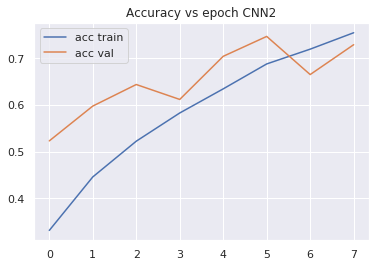


------ Training ------
Accuracy cnn2 : 0.8664045354791514
F1-score None cnn2 : [0.81758581 0.91254158 0.96083739 0.78256546]
F1-score macro cnn2 : 0.8683825603218311

------ Validation ------
Accuracy cnn2 : 0.7295373665480427
F1-score None cnn2 : [0.62773723 0.47058824 0.56603774 0.8056338 ]
F1-score macro cnn2 : 0.6174992500593619

------ Testing ------
Accuracy cnn2 : 0.7355533790401567
F1-score None cnn2 : [0.15827338 0.1443299  0.58937198 0.84052533]
F1-score macro cnn2 : 0.43312514680217884


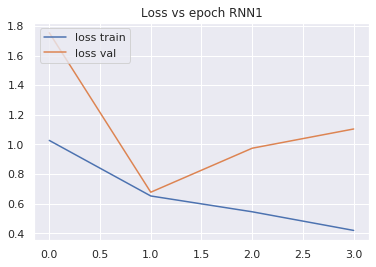

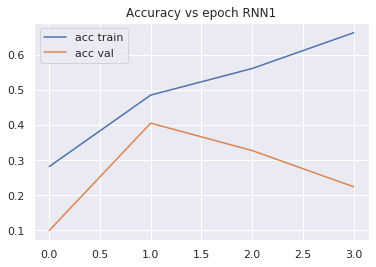


------ Training ------
Accuracy rnn1 : 0.6278346744696416
F1-score None rnn1 : [0.66870496 0.62625538 0.8465355  0.15693904]
F1-score macro rnn1 : 0.5746087195625955

------ Validation ------
Accuracy rnn1 : 0.22419928825622776
F1-score None rnn1 : [0.4137931  0.08839779 0.47368421 0.13756614]
F1-score macro rnn1 : 0.27836031039899445

------ Testing ------
Accuracy rnn1 : 0.1929480901077375
F1-score None rnn1 : [0.11940299 0.15748031 0.46557377 0.13793103]
F1-score macro rnn1 : 0.22009702625245464


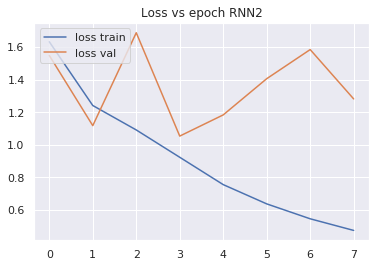

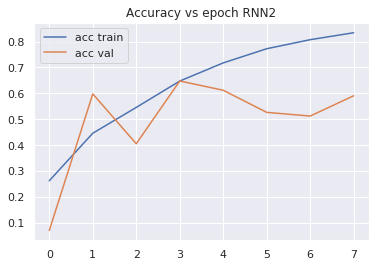


------ Training ------
Accuracy rnn2 : 0.8803035844915874
F1-score None rnn2 : [0.8417802  0.92183693 0.95733042 0.80245133]
F1-score macro rnn2 : 0.8808497188369737

------ Validation ------
Accuracy rnn2 : 0.5907473309608541
F1-score None rnn2 : [0.49681529 0.2        0.53571429 0.69902913]
F1-score macro rnn2 : 0.48288967463802046

------ Testing ------
Accuracy rnn2 : 0.6209598432908913
F1-score None rnn2 : [0.20967742 0.10884354 0.48543689 0.76335878]
F1-score macro rnn2 : 0.3918291571499106


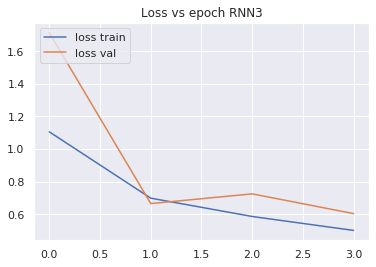

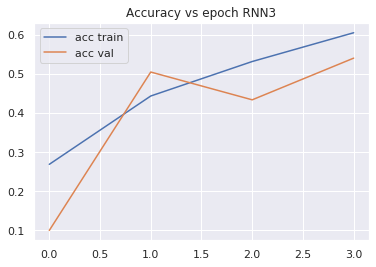


------ Training ------
Accuracy rnn3 : 0.6744696415508412
F1-score None rnn3 : [0.68110919 0.64825254 0.81837856 0.51456107]
F1-score macro rnn3 : 0.6655753382828757

------ Validation ------
Accuracy rnn3 : 0.5409252669039146
F1-score None rnn3 : [0.55757576 0.16       0.56097561 0.59622642]
F1-score macro rnn3 : 0.46869444560654877

------ Testing ------
Accuracy rnn3 : 0.4877571008814887
F1-score None rnn3 : [0.26612903 0.22560976 0.54785479 0.59329321]
F1-score macro rnn3 : 0.40822169526421836

Entrenando exec  4 



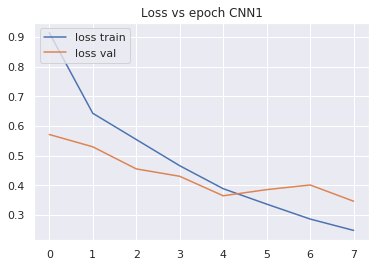

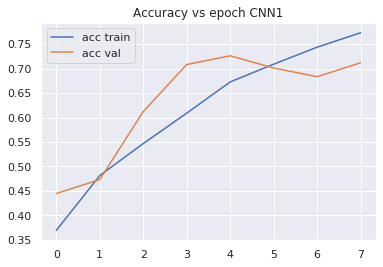


------ Training ------
Accuracy cnn1 : 0.8626554498902707
F1-score None cnn1 : [0.78378378 0.92858518 0.96108533 0.7806019 ]
F1-score macro cnn1 : 0.8635140477236081

------ Validation ------
Accuracy cnn1 : 0.7117437722419929
F1-score None cnn1 : [0.48148148 0.25       0.70967742 0.79787234]
F1-score macro cnn1 : 0.559757810315463

------ Testing ------
Accuracy cnn1 : 0.7668952007835456
F1-score None cnn1 : [0.02352941 0.15730337 0.61802575 0.85993884]
F1-score macro cnn1 : 0.4146993428861684


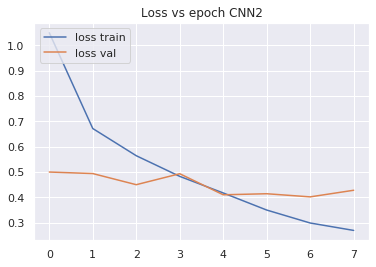


------ Training ------
Accuracy cnn2 : 0.7715801024140454
F1-score None cnn2 : [0.81620176 0.74430264 0.88955703 0.67483818]
F1-score macro cnn2 : 0.7812249008317389

------ Validation ------
Accuracy cnn2 : 0.701067615658363
F1-score None cnn2 : [0.61643836 0.15384615 0.41025641 0.78571429]
F1-score macro cnn2 : 0.4915638014953083

------ Testing ------
Accuracy cnn2 : 0.7267384916748286
F1-score None cnn2 : [0.08823529 0.02702703 0.36       0.84185493]
F1-score macro cnn2 : 0.3292793139365847


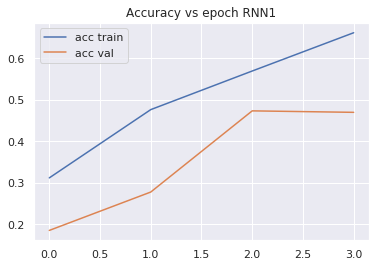


------ Training ------
Accuracy rnn1 : 0.6152158010241404
F1-score None rnn1 : [0.68470301 0.52741117 0.71252943 0.47746741]
F1-score macro rnn1 : 0.6005277541968679

------ Validation ------
Accuracy rnn1 : 0.4697508896797153
F1-score None rnn1 : [0.5        0.15789474 0.37037037 0.55172414]
F1-score macro rnn1 : 0.39499731128587756

------ Testing ------
Accuracy rnn1 : 0.4495592556317336
F1-score None rnn1 : [0.23952096 0.14876033 0.30714286 0.57621441]
F1-score macro rnn1 : 0.31790963779133397



------ Training ------
Accuracy rnn2 : 0.8771031455742502
F1-score None rnn2 : [0.82830302 0.92827638 0.95442165 0.80185553]
F1-score macro rnn2 : 0.878214144214088

------ Validation ------
Accuracy rnn2 : 0.6512455516014235
F1-score None rnn2 : [0.56115108 0.15       0.60714286 0.75840979]
F1-score macro rnn2 : 0.5191759305530674

------ Testing ------
Accuracy rnn2 : 0.672869735553379
F1-score None rnn2 : [0.11382114 0.20212766 0.48868778 0.80397351]
F1-score macro rnn2 : 0.4021525226312637


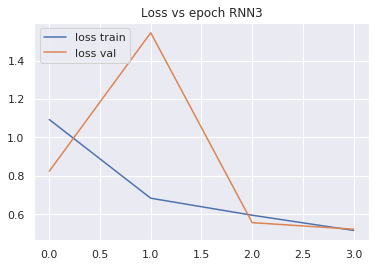

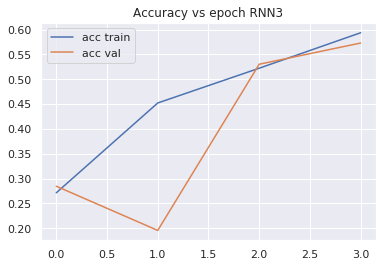


------ Training ------
Accuracy rnn3 : 0.6415508412582297
F1-score None rnn3 : [0.69225173 0.65166984 0.72665194 0.50605413]
F1-score macro rnn3 : 0.6441569090419696

------ Validation ------
Accuracy rnn3 : 0.5729537366548043
F1-score None rnn3 : [0.55263158 0.15625    0.70967742 0.64788732]
F1-score macro rnn3 : 0.5166115805614673

------ Testing ------
Accuracy rnn3 : 0.5220372184133203
F1-score None rnn3 : [0.23214286 0.21971831 0.5840708  0.64995958]
F1-score macro rnn3 : 0.42147288577258046

Entrenando exec  5 



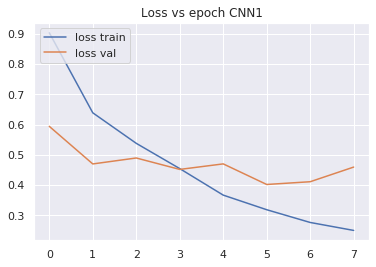

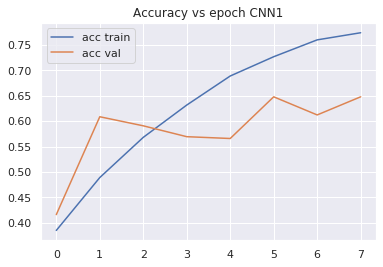


------ Training ------
Accuracy cnn1 : 0.8102596927578639
F1-score None cnn1 : [0.79918419 0.92430434 0.84951356 0.68270622]
F1-score macro cnn1 : 0.8139270765637964

------ Validation ------
Accuracy cnn1 : 0.6476868327402135
F1-score None cnn1 : [0.5698324  0.4        0.45       0.72560976]
F1-score macro cnn1 : 0.5363605395830494

------ Testing ------
Accuracy cnn1 : 0.5915768854064642
F1-score None cnn1 : [0.1920904  0.12244898 0.39473684 0.74269819]
F1-score macro cnn1 : 0.36299360227764166


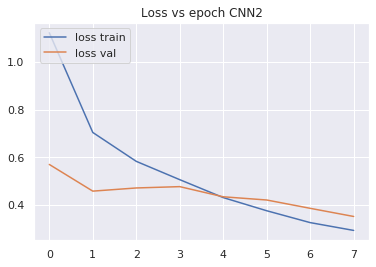

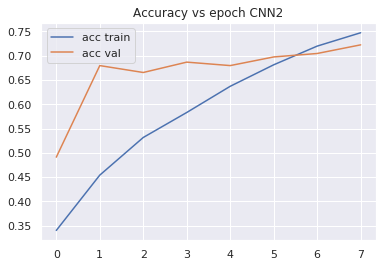


------ Training ------
Accuracy cnn2 : 0.8428127286027798
F1-score None cnn2 : [0.84504472 0.81989708 0.96919174 0.74577363]
F1-score macro cnn2 : 0.8449767909521474

------ Validation ------
Accuracy cnn2 : 0.7224199288256228
F1-score None cnn2 : [0.61643836 0.26666667 0.64       0.7977208 ]
F1-score macro cnn2 : 0.580206455137962

------ Testing ------
Accuracy cnn2 : 0.7208619000979432
F1-score None cnn2 : [0.18292683 0.05063291 0.50793651 0.83354037]
F1-score macro cnn2 : 0.39375915531700334


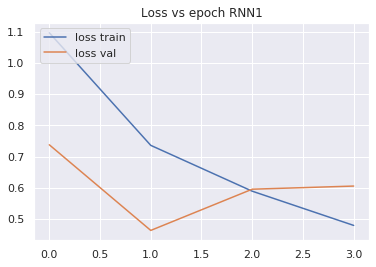

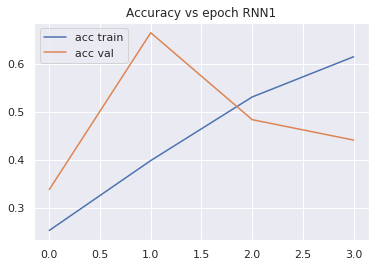


------ Training ------
Accuracy rnn1 : 0.5825713240673006
F1-score None rnn1 : [0.62971731 0.35641843 0.76664753 0.38576779]
F1-score macro rnn1 : 0.5346377652106828

------ Validation ------
Accuracy rnn1 : 0.4412811387900356
F1-score None rnn1 : [0.53921569 0.19047619 0.44247788 0.375     ]
F1-score macro rnn1 : 0.3867924382142237

------ Testing ------
Accuracy rnn1 : 0.3780607247796278
F1-score None rnn1 : [0.20134228 0.15841584 0.42154567 0.45548266]
F1-score macro rnn1 : 0.30919661314472213


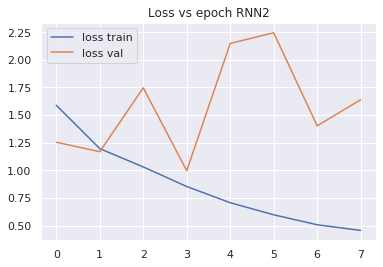

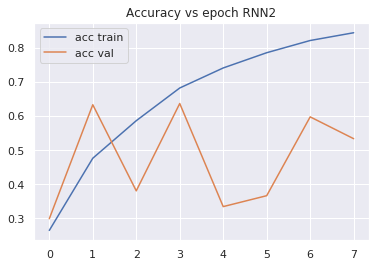


------ Training ------
Accuracy rnn2 : 0.8371433796634967
F1-score None rnn2 : [0.84272434 0.90151366 0.8440081  0.75848538]
F1-score macro rnn2 : 0.8366828725107001

------ Validation ------
Accuracy rnn2 : 0.5338078291814946
F1-score None rnn2 : [0.52112676 0.06666667 0.42990654 0.62897527]
F1-score macro rnn2 : 0.4116688085759474

------ Testing ------
Accuracy rnn2 : 0.5729676787463271
F1-score None rnn2 : [0.13114754 0.1509434  0.41826923 0.71503366]
F1-score macro rnn2 : 0.3538484563553217


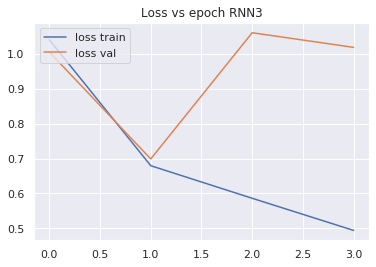

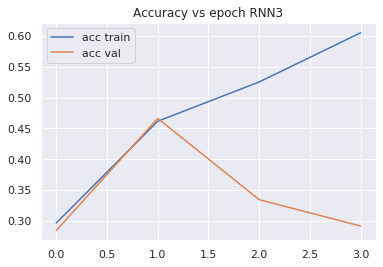


------ Training ------
Accuracy rnn3 : 0.5487381126554499
F1-score None rnn3 : [0.67224275 0.55510204 0.61572103 0.15149586]
F1-score macro rnn3 : 0.4986404210593932

------ Validation ------
Accuracy rnn3 : 0.2918149466192171
F1-score None rnn3 : [0.49032258 0.11764706 0.32727273 0.14659686]
F1-score macro rnn3 : 0.27045980634504035

------ Testing ------
Accuracy rnn3 : 0.1958863858961802
F1-score None rnn3 : [0.13131313 0.13584906 0.26758621 0.16861827]
F1-score macro rnn3 : 0.17584166544809482


In [26]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [27]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 BERT Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 BERT Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 BERT Ponderado - Accuracy promedio para",key,":" ,temp/5)

0.15 BERT Ponderado - F1-score promedio para cnn1 : [0.15339503 0.16121643 0.52774487 0.7834401 ]
0.15 BERT Ponderado - F1-score promedio para cnn2 : [0.16583012 0.08677128 0.4946095  0.81200527]
0.15 BERT Ponderado - F1-score promedio para rnn1 : [0.17331807 0.14314055 0.37690854 0.3455827 ]
0.15 BERT Ponderado - F1-score promedio para rnn2 : [0.13682918 0.18270052 0.45324687 0.75711159]
0.15 BERT Ponderado - F1-score promedio para rnn3 : [0.22507003 0.19305901 0.4543843  0.48130742]

0.15 BERT Ponderado - F1-score macro promedio para cnn1 : 0.4064491053003129 desvest:  0.0222196135085825
0.15 BERT Ponderado - F1-score macro promedio para cnn2 : 0.3898040438779093 desvest:  0.034155538581574184
0.15 BERT Ponderado - F1-score macro promedio para rnn1 : 0.2597374638502293 desvest:  0.10899817373359678
0.15 BERT Ponderado - F1-score macro promedio para rnn2 : 0.38247203980919575 desvest:  0.018006304285436554
0.15 BERT Ponderado - F1-score macro promedio para rnn3 : 0.33845518929306767 d